In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
from textwrap import wrap
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
plt.rcParams['font.size'] = 12

In [2]:
image_path = '/LAB/Image Captioning/flickr8k_Dataset/Images'
data = pd.read_csv("/LAB/Image Captioning/flickr8k_Dataset/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [3]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/LAB/Image Captioning/flickr8k_Dataset/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

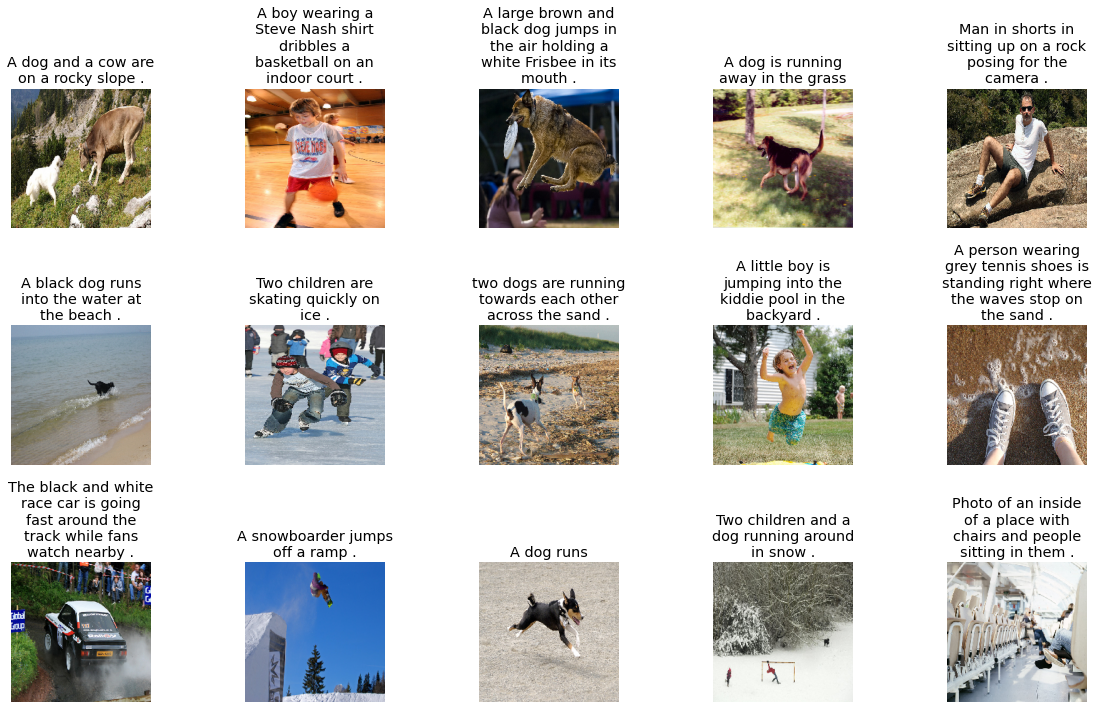

In [4]:
display_images(data.sample(15))

In [5]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "start "+data['caption']+" end"
    return data

In [6]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['start child in pink dress is climbing up set of stairs in an entry way end',
 'start girl going into wooden building end',
 'start little girl climbing into wooden playhouse end',
 'start little girl climbing the stairs to her playhouse end',
 'start little girl in pink dress going into wooden cabin end',
 'start black dog and spotted dog are fighting end',
 'start black dog and tri-colored dog playing with each other on the road end',
 'start black dog and white dog with brown spots are staring at each other in the street end',
 'start two dogs of different breeds looking at each other on the road end',
 'start two dogs on pavement moving toward each other end']

In [7]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.8*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[2, 18, 315, 63, 195, 116, 1]

In [9]:
import pickle

# Save the tokenizer to a file
tokenizer_path = "tokenizer.pkl"
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

print(f"Tokenizer saved at {tokenizer_path}")


Tokenizer saved at tokenizer.pkl


In [10]:
def tokenize_text(text, tokenizer):
    """ Tokenizes a given text using the Keras tokenizer. """
    sequence = tokenizer.texts_to_sequences([text.lower()])[0]
    return [idx_to_word(idx, tokenizer) for idx in sequence if idx is not None]  # Convert back to words


In [11]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os
from tqdm import tqdm

# Load the DenseNet201 model
base_model = DenseNet201(weights='imagenet', include_top=False, pooling='avg')
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Extract features
features = {}
image_size = 224  # Ensure it matches DenseNet201 input

for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(image_size, image_size))
    img = img_to_array(img)
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    feature = feature_extractor.predict(img, verbose=0)  # Extract feature
    features[image] = feature

2025-03-18 06:26:00.676465: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18943 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:3b:00.0, compute capability: 8.6
2025-03-18 06:26:00.678327: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22118 MB memory:  -> device: 1, name: NVIDIA RTX A5000, pci bus id: 0000:af:00.0, compute capability: 8.6


74850304/74836368 [==============================] - 14s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]2025-03-18 06:26:19.005990: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2025-03-18 06:26:22.415979: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204
100%|██████████| 8091/8091 [09:11<00:00, 14.68it/s]


In [12]:
import tensorflow as tf
import pickle
import json

# Save as Pickle
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save as JSON (Optional)
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w") as f:
    json.dump(tokenizer_json, f)

print("Tokenizer saved successfully!")

Tokenizer saved successfully!


In [13]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

        # 🔹 FIX: Pre-create one-hot encoding matrix
        self.one_hot_matrix = np.eye(self.vocab_size)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self, index):
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
        
        for image in images:
            feature = np.array(self.features[image]).squeeze()  # Ensures 1D (1920,)

            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    
                    # 🔹 FIX: Use pre-created one-hot matrix instead of `to_categorical`
                    out_seq = self.one_hot_matrix[out_seq]

                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
        
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        
        return X1, X2, y

In [14]:
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64, directory=image_path,
                                           tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)


In [19]:
tf.config.experimental.enable_tensor_float_32_execution(False)


In [20]:
from tensorflow.keras.layers import Input, Dense, Embedding, GRU, Dropout, Concatenate, Attention, RepeatVector
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Model Constants
max_length = 34  # Maximum caption length
vocab_size = 5000  # Adjust based on your tokenizer (example size)

# 🔹 Inputs
input1 = Input(shape=(1920,))  # Image feature vector
input2 = Input(shape=(max_length,))  # Tokenized caption sequence

# 🔹 Image feature processing
img_features = Dense(256, activation='relu')(input1)
img_features = RepeatVector(max_length)(img_features)  # Expand image features to match text sequence shape

# 🔹 Caption processing
sentence_features = Embedding(vocab_size, 256, mask_zero=True)(input2)

# 🔹 Merge image + text (Now their shapes match)
merged = Concatenate()([img_features, sentence_features])

# 🔹 GRU with Attention
sentence_features = GRU(256, return_sequences=True, dropout=0.3)(merged)
attention = Attention()([sentence_features, sentence_features])  # Attention applied
sentence_features = GRU(128)(attention)  # Final GRU layer

# 🔹 Fully Connected Layers
x = Dropout(0.5)(sentence_features)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# 🔹 Output Layer
output = Dense(vocab_size, activation='softmax')(x)

# 🔹 Compile Model
caption_model = Model(inputs=[input1, input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0003), metrics=['accuracy'])

# Display Model Summary
caption_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 1920)]       0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 256)          491776      input_4[0][0]                    
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 34, 256)      0           dense_3[0][0]                    
____________________________________________________________________________________________

Batch X1 shape: (3543, 1920)
Batch X2 shape: (3543, 34)
Batch y shape: (3543, 8483)


In [22]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=1e-8)


In [23]:
history = caption_model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]
)

Epoch 1/15


2025-03-18 06:43:53.123463: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA RTX A5000" frequency: 1695 num_cores: 64 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11040" } environment { key: "cudnn" value: "8204" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 19863830528 bandwidth: 768096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[3217,5000] labels_size=[3217,8483]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at tmp/ipykernel_120/4219299132.py:1) ]] [Op:__inference_train_function_481096]

Function call stack:
train_function


In [115]:
caption_model.save("final_model.h5")

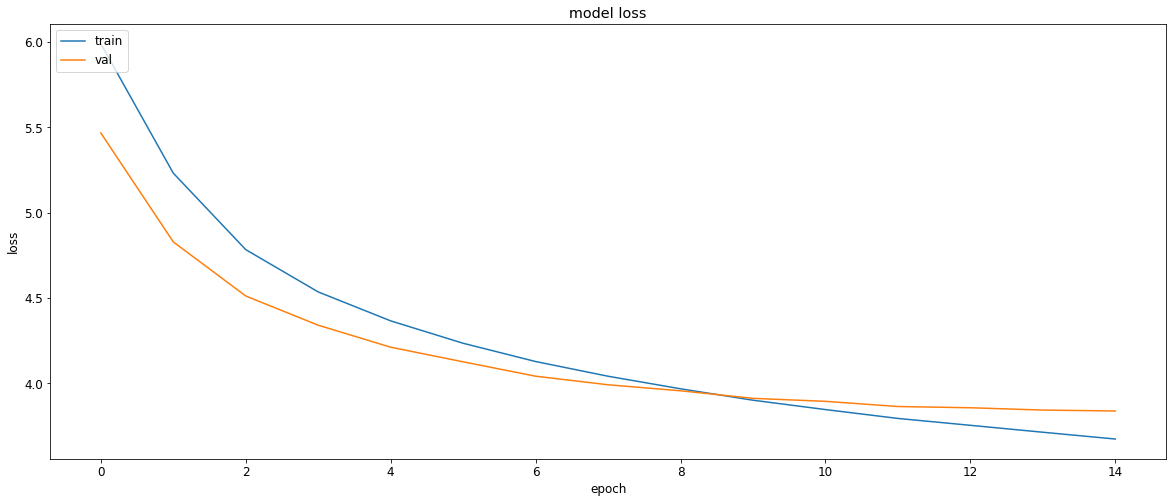

In [116]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [17]:
# def predict_caption(model, image, tokenizer, max_length, features):
#     feature = features[image]
#     in_text = "start"
#     for i in range(max_length):
#         sequence = tokenizer.texts_to_sequences([in_text])[0]
#         sequence = pad_sequences([sequence], max_length)

#         y_pred = model.predict([feature,sequence])
#         y_pred = np.argmax(y_pred)
        
#         word = idx_to_word(y_pred, tokenizer)
        
#         if word is None:
#             break
            
#         in_text+= " " + word
        
#         if word == "end":
#             break
            
#     return in_text 

In [21]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_caption_(model, image, tokenizer, max_length, features, temperature=1.0):
    """
    Generates a caption using Greedy Search but prevents word repetition.
    """
    feature = features[image].reshape((1, 1920))  # Ensure correct input shape
    in_text = ["start"]
    word_count = {}  # Dictionary to track word occurrences

    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding="post")

        y_pred = model.predict([feature, sequence], verbose=0)[0]

        # Apply temperature scaling for more diversity
        y_pred = np.exp(y_pred / temperature) / np.sum(np.exp(y_pred / temperature))

        # Select the most probable word
        y_pred_index = np.argmax(y_pred)

        word = idx_to_word(y_pred_index, tokenizer)
        if word is None:
            break

        # 🔹 Stop if word repeats too many times
        word_count[word] = word_count.get(word, 0) + 1
        if word_count[word] > 2:  # If a word appears more than twice, stop
            break

        in_text.append(word)
        if word == "end":
            break

    return " ".join(in_text[1:-1])  # Remove "start" and "end"

In [22]:
samples = test.sample(40)
samples.reset_index(drop=True,inplace=True)

In [23]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption_(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

2025-03-01 09:00:18.988293: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA RTX A5000" frequency: 1695 num_cores: 64 environment { key: "architecture" value: "8.6" } environment { key: "cuda" value: "11040" } environment { key: "cudnn" value: "8204" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 6291456 shared_memory_size_per_multiprocessor: 102400 memory_size: 23193059328 bandwidth: 768096000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


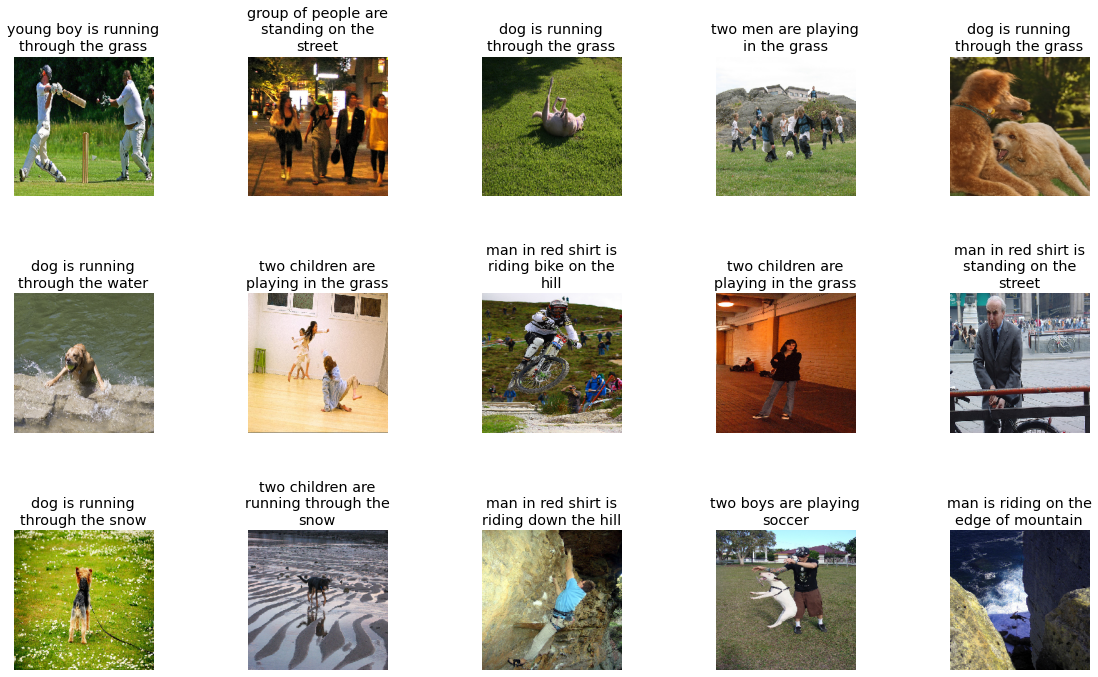

In [24]:
display_images(samples)

In [26]:
import numpy as np
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction

nltk.download('punkt')

def evaluate_bleu_score(model, tokenizer, features, test_data, max_length):
    print("\n🚀 Starting BLEU Score Evaluation...")
    
    all_references = []
    all_hypotheses = []
    bleu_scores = []
    
    smoothing_function = SmoothingFunction().method1
    grouped_test_data = test_data.groupby("image")["caption"].apply(list).reset_index()
    
    for _, record in grouped_test_data.iterrows():
        image_name = record["image"]
        reference_captions = record["caption"]
        
        generated_caption = predict_caption_(model, image_name, tokenizer, max_length, features)
        
        reference_tokens = [ref.split() for ref in reference_captions]
        generated_tokens = generated_caption.split()
        
        if len(generated_tokens) < 2:
            continue
        
        # 🔹 Compute BLEU Score for This Image
        
        bleu1 = sentence_bleu(reference_tokens, generated_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
        bleu2 = sentence_bleu(reference_tokens, generated_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
        bleu3 = sentence_bleu(reference_tokens, generated_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function)
        bleu4 = sentence_bleu(reference_tokens, generated_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)

        print(f"🔹 BLEU-1: {bleu1:.4f} | BLEU-2: {bleu2:.4f} | BLEU-3: {bleu3:.4f} | BLEU-4: {bleu4:.4f}")
        
        print(f"\n📷 Image: {image_name}")
        print(f"🔹 Reference Captions: {reference_captions}")
        print(f"🔹 Generated Caption: {generated_caption}")
        print(f"🔹 BLEU-1 Score: {bleu1:.4f}")
        
        bleu_scores.append(bleu1)
        all_references.append(reference_tokens)
        all_hypotheses.append(generated_tokens)
    
    corpus_bleu_score = corpus_bleu(all_references, all_hypotheses, smoothing_function=smoothing_function)
    
    print("\n📊 BLEU Score Summary:")
    print(f"🔹 Mean BLEU-1 Score: {np.mean(bleu_scores):.4f}")
    print(f"🏆 Final Corpus BLEU Score: {corpus_bleu_score:.4f}")
    
    return corpus_bleu_score

bleu_score = evaluate_bleu_score(caption_model, tokenizer, features, test, max_length)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



🚀 Starting BLEU Score Evaluation...
🔹 BLEU-1: 0.5714 | BLEU-2: 0.4364 | BLEU-3: 0.3402 | BLEU-4: 0.1757

📷 Image: 3601803640_5f3cb05acf.jpg
🔹 Reference Captions: ['start man and woman kissing end', 'start man and woman kissing in front of crowd of people end', 'start man is kissing woman end', 'start young couple kiss while crowd mills in the background on sunny day end', 'start two people kiss near crowd end']
🔹 Generated Caption: two children are playing in the background
🔹 BLEU-1 Score: 0.5714
🔹 BLEU-1: 0.4286 | BLEU-2: 0.0845 | BLEU-3: 0.0538 | BLEU-4: 0.0435

📷 Image: 3601843201_4809e66909.jpg
🔹 Reference Captions: ['start man racing on motorbike end', 'start motorcycle rider drives fast around curve on track end', 'start person wearing red and white uniform is racing motorcycle with the number 58 on it end', 'start red and white motorcycle is being ridden around bend on racetrack end', 'start red and white motorbike number 58 races around the track end']
🔹 Generated Caption: man

🔹 BLEU-1: 0.4954 | BLEU-2: 0.3783 | BLEU-3: 0.2949 | BLEU-4: 0.1523

📷 Image: 3605061440_1d08c80a57.jpg
🔹 Reference Captions: ['start children one with stick and six petting dog with blue leash end', 'start group of children are petting white dog on the grass end', 'start group of children gather around white dog on the grass outside end', 'start group of children playing with dog end', 'start group of children surround and pet white dog with blue collar on grass end']
🔹 Generated Caption: two people are standing on the grass
🔹 BLEU-1 Score: 0.4954
🔹 BLEU-1: 0.4294 | BLEU-2: 0.3280 | BLEU-3: 0.1196 | BLEU-4: 0.0742

📷 Image: 3605100550_01214a1224.jpg
🔹 Reference Captions: ['start big dog barking at small dog through fence end', 'start brown and white dog barking through the fence at smaller black and white dog end', 'start the big dog is looking through the fence at the small dog end', 'start the larger dog is barking at the smaller dog end', 'start two dogs fighting with fence between

🔹 BLEU-1: 0.4022 | BLEU-2: 0.3671 | BLEU-3: 0.3135 | BLEU-4: 0.1782

📷 Image: 3608752424_01a1cfd8a6.jpg
🔹 Reference Captions: ['start couple of dogs running through the water with trees in the background end', 'start two dogs are running through small pond end', 'start two dogs play in river one is making splash end', 'start two dogs run through the water near trees end', 'start two dogs standing in lake end']
🔹 Generated Caption: dog running through the snow
🔹 BLEU-1 Score: 0.4022
🔹 BLEU-1: 0.6441 | BLEU-2: 0.5681 | BLEU-3: 0.4617 | BLEU-4: 0.2066

📷 Image: 3608849440_e7d2bed29f.jpg
🔹 Reference Captions: ['start group of children play in the grass at park end', 'start kids are playing game of ball outdoors end', 'start kids playing on lawn with flag and parking lot nearby end', 'start three children are playing with balls near to an american flag end', 'start three kids playing with balls on lawn end']
🔹 Generated Caption: two children are playing in the grass
🔹 BLEU-1 Score: 0.6441
🔹

🔹 BLEU-1: 0.8889 | BLEU-2: 0.5774 | BLEU-3: 0.3662 | BLEU-4: 0.1678

📷 Image: 3612249030_e2829ffa31.jpg
🔹 Reference Captions: ['start boy carries boogieboard on the beach end', 'start boy is carrying black body board across the sand end', 'start boy standing on beach end', 'start kid in black carrying cushion end', 'start young boy wearing spider-patterned shirt on the sand end']
🔹 Generated Caption: boy in red shirt is standing on the beach
🔹 BLEU-1 Score: 0.8889
🔹 BLEU-1: 0.5556 | BLEU-2: 0.2635 | BLEU-3: 0.1021 | BLEU-4: 0.0638

📷 Image: 3612484827_0e479f9ee8.jpg
🔹 Reference Captions: ['start man is on the back of his friend end', 'start man jumps on another mans back end', 'start the guys in white shirts horse around near park end', 'start two men do trick in park end', 'start two teenagers are playing wrestling game in the park end']
🔹 Generated Caption: man in red shirt is jumping on the street
🔹 BLEU-1 Score: 0.5556
🔹 BLEU-1: 0.4444 | BLEU-2: 0.3333 | BLEU-3: 0.1192 | BLEU-4: 0.

🔹 BLEU-1: 0.7054 | BLEU-2: 0.6911 | BLEU-3: 0.6734 | BLEU-4: 0.6432

📷 Image: 3613667665_1881c689ea.jpg
🔹 Reference Captions: ['start black dog runs across the water at beach while another follows end', 'start pair of black dogs runs in the surf end', 'start dogs run in the surf end', 'start the black dog is running through the water on the beach end', 'start two black dogs splash through the waves on beach end']
🔹 Generated Caption: dog is running through the snow
🔹 BLEU-1 Score: 0.7054
🔹 BLEU-1: 0.4044 | BLEU-2: 0.0700 | BLEU-3: 0.0432 | BLEU-4: 0.0350

📷 Image: 3613705104_46d854134e.jpg
🔹 Reference Captions: ['start boy skateboards off ramp covered in graffiti end', 'start male skateboarder is skating in vandalized skate park end', 'start man does jump on skateboard surrounded by graffiti end', 'start man does skating trick off of graffiti-filled stairs end', 'start skateboarder skates down stairs covered in graffiti end']
🔹 Generated Caption: man is riding bike on ramp
🔹 BLEU-1 Sco

🔹 BLEU-1: 0.4294 | BLEU-2: 0.0733 | BLEU-3: 0.0445 | BLEU-4: 0.0351

📷 Image: 3618504267_d7eaa495d0.jpg
🔹 Reference Captions: ['start guy and white dog standing on grass end', 'start man and woman walk their small dogs at an outdoor event end', 'start man is encouraging small white dog to stand on its hind legs in dog show end', 'start at an outdoor dog show very small dog jumps on an older man end', 'start mutltiple people are walking small dogs near tent end']
🔹 Generated Caption: two dogs are playing in the grass
🔹 BLEU-1 Score: 0.4294
🔹 BLEU-1: 0.3977 | BLEU-2: 0.0667 | BLEU-3: 0.0397 | BLEU-4: 0.0303

📷 Image: 3618525295_d32d634b2e.jpg
🔹 Reference Captions: ['start dog sits with woman in an outdoor cafe end', 'start woman and her dog sitting at an outdoor cafe table end', 'start people walk and sit to eat at an outside cafe where dog is near woman end', 'start the dog begs for some food at local restaurant end', 'start two pedestrians passing restaurant look at the dog that is loo

🔹 BLEU-1: 0.3583 | BLEU-2: 0.2266 | BLEU-3: 0.0992 | BLEU-4: 0.0685

📷 Image: 3621652774_fd9634bd5b.jpg
🔹 Reference Captions: ['start baby in pool splashing water in the air end', 'start small baby boy sits in water with his hands up splashing water droplets end', 'start toddler catches droplets of water as he sits in shallow pool end', 'start young boy catching stream of water end', 'start baby sitting in blue plastic pool while water drips onto its hands end']
🔹 Generated Caption: young boy is jumping into pool
🔹 BLEU-1 Score: 0.3583
🔹 BLEU-1: 0.8571 | BLEU-2: 0.3780 | BLEU-3: 0.1447 | BLEU-4: 0.0919

📷 Image: 3621717946_d96f8a6012.jpg
🔹 Reference Captions: ['start person hits yellow volleyball over the net to her opponent in pool end', 'start people are playing water volleyball end', 'start two people play water volleyball in pool end', 'start two swimmers are playing water sport with yellow ball and net end', 'start two swimmers in pool play at net with water polo ball end']
🔹 Gene

🔹 BLEU-1: 0.4286 | BLEU-2: 0.0845 | BLEU-3: 0.0538 | BLEU-4: 0.0435

📷 Image: 3626642428_3396568c3c.jpg
🔹 Reference Captions: ['start group of dogs standing in river end', 'start large group of dogs walking in body of water end', 'start dogs play in creek end', 'start six dogs swimming in river end', 'start there are six dogs in the water end']
🔹 Generated Caption: two dogs are running through the snow
🔹 BLEU-1 Score: 0.4286
🔹 BLEU-1: 0.6960 | BLEU-2: 0.5580 | BLEU-3: 0.4334 | BLEU-4: 0.1856

📷 Image: 3626689571_5817f99c0e.jpg
🔹 Reference Captions: ['start man in pink shirt is standing in basketball court holding basketball end', 'start young adult male stands with basketball on court end', 'start guy holding basketball wearing red shirt black shorts with something on left leg end', 'start tall man in red and black stands outside holding basketball end', 'start the man with the red shirt is holding basketball and is in front of basketball hoop end']
🔹 Generated Caption: man in red shir

🔹 BLEU-1: 0.4000 | BLEU-2: 0.2981 | BLEU-3: 0.2265 | BLEU-4: 0.1122

📷 Image: 3629492654_619d7b67ee.jpg
🔹 Reference Captions: ['start backlit skateboarder ollies over parking cone end', 'start boy does skateboard tricks at sundown end', 'start man on skateboard jumping an orange cone end', 'start silhouette of skateboarder in the air end', 'start skateboarder in silhouette jumps over an orange traffic cone end']
🔹 Generated Caption: man in red shirt is riding bike in the air
🔹 BLEU-1 Score: 0.4000
🔹 BLEU-1: 0.8333 | BLEU-2: 0.7071 | BLEU-3: 0.5035 | BLEU-4: 0.2541

📷 Image: 3629664676_36bcefe6b7.jpg
🔹 Reference Captions: ['start black dog pulling green rope end', 'start black dog pulling on green rope in the grass end', 'start black dog tugs on rope end', 'start dog pulling rope end', 'start the black dog is tugging at green rope end']
🔹 Generated Caption: dog is running in the grass
🔹 BLEU-1 Score: 0.8333
🔹 BLEU-1: 1.0000 | BLEU-2: 0.8452 | BLEU-3: 0.6228 | BLEU-4: 0.2627

📷 Image: 36

🔹 BLEU-1: 0.3583 | BLEU-2: 0.2266 | BLEU-3: 0.0992 | BLEU-4: 0.0685

📷 Image: 3632258003_6a0a69bf3a.jpg
🔹 Reference Captions: ['start group of men with shovels are digging in salt end', 'start four men shovel what looks like sand end', 'start men shovel snow while wearing shorts end', 'start men with shovels shoveling white sand end', 'start these four men two shirtless are shoveling sand end']
🔹 Generated Caption: group of people are playing soccer
🔹 BLEU-1 Score: 0.3583
🔹 BLEU-1: 0.5000 | BLEU-2: 0.1000 | BLEU-3: 0.0648 | BLEU-4: 0.0537

📷 Image: 3632572264_577703b384.jpg
🔹 Reference Captions: ['start sports team is lined up outside end', 'start two african soccer teams posing for picture end', 'start two soccer teams posing end', 'start two teams line up either side of pylon on barren playing field end', 'start two teams stand in line on field end']
🔹 Generated Caption: group of people are playing soccer
🔹 BLEU-1 Score: 0.5000
🔹 BLEU-1: 0.4777 | BLEU-2: 0.2616 | BLEU-3: 0.1091 | BLE

🔹 BLEU-1: 0.4286 | BLEU-2: 0.0845 | BLEU-3: 0.0538 | BLEU-4: 0.0435

📷 Image: 363617160_6cb0c723be.jpg
🔹 Reference Captions: ['start girl bends down to paint something underneath her end', 'start girl is holding paint brush in plastic cup and painting the ground end', 'start girl paints the road end', 'start little girl painting the sidwalk white end', 'start little girl paints the ground white outside end']
🔹 Generated Caption: young boy is jumping down the sidewalk
🔹 BLEU-1 Score: 0.4286
🔹 BLEU-1: 0.0000 | BLEU-2: 0.0000 | BLEU-3: 0.0000 | BLEU-4: 0.0000

📷 Image: 3636247381_65ccf8f106.jpg
🔹 Reference Captions: ['start baseball is being thrown at volleyball net end', 'start boy whose head has been replaced by baseball end', 'start child hits baseball into net end', 'start child is throwing baseball into net end', 'start young boy with baseball obscuring his face through net end']
🔹 Generated Caption: two men are playing soccer
🔹 BLEU-1 Score: 0.0000
🔹 BLEU-1: 0.5714 | BLEU-2: 0.0976 

🔹 BLEU-1: 0.4000 | BLEU-2: 0.2981 | BLEU-3: 0.1059 | BLEU-4: 0.0631

📷 Image: 3638688673_176f99d7fd.jpg
🔹 Reference Captions: ['start boy in swing end', 'start boy swings on swing set end', 'start child at the height of swing end', 'start young boy swinging on swing end', 'start young boy swings in the air end']
🔹 Generated Caption: young boy in blue shirt is jumping down the slide
🔹 BLEU-1 Score: 0.4000
🔹 BLEU-1: 0.2000 | BLEU-2: 0.1491 | BLEU-3: 0.0671 | BLEU-4: 0.0446

📷 Image: 3638783120_f600ceb19d.jpg
🔹 Reference Captions: ['start man swings golf club while the person to his left waves an arm end', 'start man teeing off on golf course with large building in the background end', 'start two men are standing on golf course with large ornate building in the background end', 'start two people are on golf course playing golf end', 'start two people are playing golf on golf course end']
🔹 Generated Caption: young girl in red shirt is running in the grass
🔹 BLEU-1 Score: 0.2000
🔹 BLEU-1: 

🔹 BLEU-1: 0.3333 | BLEU-2: 0.0550 | BLEU-3: 0.0323 | BLEU-4: 0.0241

📷 Image: 3640109324_3ce89e4d1a.jpg
🔹 Reference Captions: ['start group of men carry silver coffin end', 'start men carry small structure on their shoulders while others play instruments behind end', 'start men in blue carrying something on their shoulders followed by band end', 'start pall bearers at catholic funeral end', 'start the men are wearing purple and carrying silver casket end']
🔹 Generated Caption: man in red shirt and black shirt is sitting on the street
🔹 BLEU-1 Score: 0.3333
🔹 BLEU-1: 0.4286 | BLEU-2: 0.0845 | BLEU-3: 0.0538 | BLEU-4: 0.0435

📷 Image: 3640241166_b1ab7a8e7a.jpg
🔹 Reference Captions: ['start smiling young brunette woman carries black video camera in her hand end', 'start smiling young woman holds video camera and walks through park end', 'start white woman holding panasonic video camera in park end', 'start woman holding video camera end', 'start young woman is standing on the grass with v

🔹 BLEU-1: 0.4286 | BLEU-2: 0.0845 | BLEU-3: 0.0538 | BLEU-4: 0.0435

📷 Image: 36422830_55c844bc2d.jpg
🔹 Reference Captions: ['start four wheel drive car is navigating along rocky off road trail end', 'start jeep sidewalks on some rocks end', 'start red jeep hangs from the edge of rocky cliff as girl looks on end', 'start red truck is driving over rocky surface end', 'start woman stands next to red suv that has run off into ditch end']
🔹 Generated Caption: the man is jumping over the air
🔹 BLEU-1 Score: 0.4286
🔹 BLEU-1: 0.4286 | BLEU-2: 0.2673 | BLEU-3: 0.1151 | BLEU-4: 0.0773

📷 Image: 3643074723_94d42b7a0c.jpg
🔹 Reference Captions: ['start boy laying on sitting swing face down wearing hat backwards end', 'start boy laying on his stomach on swing end', 'start boy plays on the swing end', 'start child in sunglasses lays on his belly on red swing set end', 'start young boy plays on swing end']
🔹 Generated Caption: young girl is standing on the beach
🔹 BLEU-1 Score: 0.4286
🔹 BLEU-1: 0.857

🔹 BLEU-1: 0.4022 | BLEU-2: 0.2596 | BLEU-3: 0.1167 | BLEU-4: 0.0843

📷 Image: 3647446816_bd4383c828.jpg
🔹 Reference Captions: ['start girl playing softball slides into home plate end', 'start girl slides in for homerun end', 'start runner is safe at home plate at youth softball game end', 'start two girls are playing softball and one is sliding to the home plate end', 'start two girls play softball one slides into plate as other fails to catch ball end']
🔹 Generated Caption: two men are playing basketball
🔹 BLEU-1 Score: 0.4022
🔹 BLEU-1: 0.5000 | BLEU-2: 0.2357 | BLEU-3: 0.0907 | BLEU-4: 0.0561

📷 Image: 3647693147_0d0434351b.jpg
🔹 Reference Captions: ['start boy throws leaves into the air end', 'start child looks at leaves blowing in the wind in the woods end', 'start small young boy wearing white shirt is playing with fallen leaves outside end', 'start boy playing with leaves in the woods end', 'start young boy plays with leaves in green wooded area end']
🔹 Generated Caption: young g

🔹 BLEU-1: 0.5000 | BLEU-2: 0.1961 | BLEU-3: 0.0703 | BLEU-4: 0.0413

📷 Image: 3650188378_cc8aea89f0.jpg
🔹 Reference Captions: ['start man and woman are dressed up as ghost busters on city street end', 'start people in ghostbusters outfits stand on sidewalk end', 'start three ghostbuster impersonators end', 'start three people in uniform are outdoors and are observing scene which is out of the picture end', 'start two people dressed up like the ghostbusters standing on the sidewalk end']
🔹 Generated Caption: man in red shirt is sitting on the street of man in red shirt
🔹 BLEU-1 Score: 0.5000
🔹 BLEU-1: 0.8669 | BLEU-2: 0.3539 | BLEU-3: 0.1320 | BLEU-4: 0.0828

📷 Image: 3650986674_3e101c606b.jpg
🔹 Reference Captions: ['start brown dog and tan dog run on beach end', 'start dogs chase each other through water end', 'start the black dog and the brown dog are on the ground end', 'start two dogs play in shallow water end', 'start two dogs running on the beach end']
🔹 Generated Caption: two dog

🔹 BLEU-1: 0.3333 | BLEU-2: 0.0645 | BLEU-3: 0.0403 | BLEU-4: 0.0316

📷 Image: 3653837067_94050699ec.jpg
🔹 Reference Captions: ['start woman riding horse in show jumping competition end', 'start the horse and rider are jumping over fence end', 'start the horse and rider are jumping over white fence end', 'start the horseback rider and her horse are jumping rails end', 'start women on horse jumping over gate end']
🔹 Generated Caption: man in red shirt is jumping down the street
🔹 BLEU-1 Score: 0.3333
🔹 BLEU-1: 0.3583 | BLEU-2: 0.0717 | BLEU-3: 0.0464 | BLEU-4: 0.0385

📷 Image: 3654103642_075f8af4f4.jpg
🔹 Reference Captions: ['start brown dog and white dog run along an ocean shoreline end', 'start white dog and brown dog run alongside each other at the beach end', 'start two dogs are running on beach end', 'start two dogs chase along the beach end', 'start two dogs one white and one brown are running together on beach end']
🔹 Generated Caption: dog is running through the snow
🔹 BLEU-1 Sco

🔹 BLEU-1: 0.1613 | BLEU-2: 0.0390 | BLEU-3: 0.0266 | BLEU-4: 0.0222

📷 Image: 3657016761_d553e514d9.jpg
🔹 Reference Captions: ['start child at water park is sprayed from all sides by ring of water end', 'start child in pink and black bathing suit walks through water mist from colored rings end', 'start young girl stands under three large rings that shoot water in water park end', 'start colorful rings spraying water at little girl wearing swimsuit end', 'start the little girl in her bathing suit stands near the sprinkers and squeals end']
🔹 Generated Caption: two children are playing in the snow
🔹 BLEU-1 Score: 0.1613
🔹 BLEU-1: 0.5556 | BLEU-2: 0.0833 | BLEU-3: 0.0477 | BLEU-4: 0.0359

📷 Image: 3657209354_cde9bbd2c5.jpg
🔹 Reference Captions: ['start hiker posing on cliff high in the mountains end', 'start man sitting at the top of mountain end', 'start person wearing hat and glasses sits on cliff and smiles end', 'start woman sitting on high cliff end', 'start the hiker poses for photo

🔹 BLEU-1: 0.3309 | BLEU-2: 0.0646 | BLEU-3: 0.0407 | BLEU-4: 0.0323

📷 Image: 3662871327_b128d25f04.jpg
🔹 Reference Captions: ['start three friends making faces for the camera end', 'start three people posing for picture with one man giving kissing face end', 'start three young adults pose for the camera end', 'start two men and girl pose with funny faces in front of wood panel wall end', 'start young man with upturned hair posing with young man with sunglasses and woman with glasses end']
🔹 Generated Caption: man in red shirt and black shirt and
🔹 BLEU-1 Score: 0.3309
🔹 BLEU-1: 0.5714 | BLEU-2: 0.3086 | BLEU-3: 0.1266 | BLEU-4: 0.0831

📷 Image: 3662909101_21b9e59a3e.jpg
🔹 Reference Captions: ['start black dog jumping over hurdle end', 'start black dog jumps in the air over the red hurdle end', 'start black dog jumps over an obstacle end', 'start black dog jumps over show jumping hurdle end', 'start black dog running course at dog show end']
🔹 Generated Caption: black dog is running th

🔹 BLEU-1: 0.4444 | BLEU-2: 0.2357 | BLEU-3: 0.0948 | BLEU-4: 0.0603

📷 Image: 3666188047_e81e1d97a7.jpg
🔹 Reference Captions: ['start boy rides game machine end', 'start child in yellow shirt is playing red arcade ride end', 'start child rides mechanical ride end', 'start small boy is playing racing arcade game end', 'start young man playing motorcycle video game end']
🔹 Generated Caption: woman in red shirt is sitting on the street
🔹 BLEU-1 Score: 0.4444
🔹 BLEU-1: 0.2857 | BLEU-2: 0.0690 | BLEU-3: 0.0471 | BLEU-4: 0.0393

📷 Image: 3666324102_18ecdf8253.jpg
🔹 Reference Captions: ['start girl and woman jump off of their swings end', 'start two females jump off of swings end', 'start two girls jump out of swings end', 'start two girls riding on swings end', 'start two girls swing over red patterned surface end']
🔹 Generated Caption: two children are standing on the street
🔹 BLEU-1 Score: 0.2857
🔹 BLEU-1: 0.5338 | BLEU-2: 0.3269 | BLEU-3: 0.1091 | BLEU-4: 0.0636

📷 Image: 3666537170_c4ecd

🔹 BLEU-1: 0.6441 | BLEU-2: 0.4920 | BLEU-3: 0.3341 | BLEU-4: 0.1617

📷 Image: 3669564923_8fcb1a6eff.jpg
🔹 Reference Captions: ['start the girls are both eating and the girl wearing the color red has cake icing on her upper lip end', 'start two girls are eating cake and one has blue icing on her face end', 'start two girls play with their food for the camera end', 'start two little girls are eating and making mess end', 'start two young girls having fun while eating end']
🔹 Generated Caption: two girls are sitting on the camera
🔹 BLEU-1 Score: 0.6441
🔹 BLEU-1: 0.2857 | BLEU-2: 0.0690 | BLEU-3: 0.0471 | BLEU-4: 0.0393

📷 Image: 3670075789_92ea9a183a.jpg
🔹 Reference Captions: ['start child is sliding into small pool end', "start girl in child 's swimming pool end", 'start little girl is sliding down short slide into an inflatable paddling pool end', 'start girl splashing in kiddie pool end', 'start the dark-haired girl is sliding into white kiddie pool end']
🔹 Generated Caption: two child

🔹 BLEU-1: 0.3221 | BLEU-2: 0.0635 | BLEU-3: 0.0405 | BLEU-4: 0.0327

📷 Image: 3673032164_6c6843de87.jpg
🔹 Reference Captions: ['start two girls arm wrestle as another observes end', 'start two girls arm wrestle while third girl in pink shirt and glasses watches end', 'start two girls arm wrestling while another looks on end', 'start two teenage girls arm wrestle while third girl watches end', 'start two young girls are arm wrestling in their hotel room while another girl watches end']
🔹 Generated Caption: two women are sitting on the street
🔹 BLEU-1 Score: 0.3221
🔹 BLEU-1: 0.4444 | BLEU-2: 0.2357 | BLEU-3: 0.0948 | BLEU-4: 0.0603

📷 Image: 3673035152_da7ed916d9.jpg
🔹 Reference Captions: ['start girl dressed in orange flies in the air while jumping on the bed end', 'start girl is jumping on the bed end', 'start lady with yellow outfit is in the air above the bed in yellow room end', 'start little girl in an orange striped outfit is airborne whilst bouncing on bed end', 'start young girl

🔹 BLEU-1: 0.4444 | BLEU-2: 0.0745 | BLEU-3: 0.0443 | BLEU-4: 0.0339

📷 Image: 3676788491_01e9bc5f15.jpg
🔹 Reference Captions: ['start dark skinned man standing outside small yellow building which is setup to sell items end', 'start man is standing outside yellow building end', 'start man is standing outside of yellow building end', 'start man standing in front of yellow building end', 'start the man is standing next to yellow building with blue window end']
🔹 Generated Caption: man in red shirt is sitting on the street
🔹 BLEU-1 Score: 0.4444
🔹 BLEU-1: 0.3790 | BLEU-2: 0.0562 | BLEU-3: 0.0319 | BLEU-4: 0.0235

📷 Image: 3677239603_95865a9073.jpg
🔹 Reference Captions: ['start girl in lavender shirt looks puzzled end', 'start girl in purple sweater and shoulder bag is looking to the side with lot of people behind her end', 'start woman in park wearing purple blouse end', 'start woman in purple sweater has an odd look on her face end', 'start woman with brown hair is wearing purple shirt an

🔹 BLEU-1: 0.5368 | BLEU-2: 0.5186 | BLEU-3: 0.4348 | BLEU-4: 0.3510

📷 Image: 367925122_335ed279a8.jpg
🔹 Reference Captions: ['start blonde toddler in light green shirt sitting in green chair surrounded by other green chairs end', 'start cute toddler girl waits in her stroller end', 'start little blonde girl is sitting on green chair end', 'start little girl is turned around in her seat at an event end', 'start young girl with blond hair holding onto rail end']
🔹 Generated Caption: young girl is sitting on the slide
🔹 BLEU-1 Score: 0.5368
🔹 BLEU-1: 0.3750 | BLEU-2: 0.0732 | BLEU-3: 0.0461 | BLEU-4: 0.0366

📷 Image: 3679341667_936769fd0c.jpg
🔹 Reference Captions: ['start two fighters kick boxing end', 'start two people kick boxing with others spectating end', 'start two woman spar in kickboxing match end', 'start two women are kick boxing end', 'start woman kicking head of another kick boxer end']
🔹 Generated Caption: group of people are standing on the street
🔹 BLEU-1 Score: 0.3750
🔹 B

🔹 BLEU-1: 0.1011 | BLEU-2: 0.0350 | BLEU-3: 0.0273 | BLEU-4: 0.0248

📷 Image: 3682038869_585075b5ff.jpg
🔹 Reference Captions: ['start little girl is peaking out from behind tree end', 'start little girl peering out from behind tree end', 'start young girl hiding behind tree in forest end', 'start young girl peeking out from behind tree in wooded area end', 'start young girl wearing striped dress peeks out from behind tree end']
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1 Score: 0.1011
🔹 BLEU-1: 0.6960 | BLEU-2: 0.5580 | BLEU-3: 0.4334 | BLEU-4: 0.3301

📷 Image: 368212336_bc19b0bb72.jpg
🔹 Reference Captions: ['start man looking across street end', 'start man looks at the city end', 'start man standing on the street looking at woman across on the road end', 'start young man in grey sweater is looking downtown end', 'start two people stand across city intersection from each other end']
🔹 Generated Caption: man in red shirt is standing on the street
🔹 BLEU-1 Score: 0.696

🔹 BLEU-1: 0.5643 | BLEU-2: 0.3091 | BLEU-3: 0.1289 | BLEU-4: 0.0869

📷 Image: 3686924335_3c51e8834a.jpg
🔹 Reference Captions: ['start dog gets sprayed by hose end', 'start dog is being sprayed with water end', 'start dog jumping through the air getting hit by water end', 'start an animal is hosed down by brick wall end', 'start leaping dog sprayed by off screen person with hose end']
🔹 Generated Caption: dog is jumping over the grass
🔹 BLEU-1 Score: 0.5643
🔹 BLEU-1: 0.3333 | BLEU-2: 0.1741 | BLEU-3: 0.0690 | BLEU-4: 0.0428

📷 Image: 3687062281_e62f70baf3.jpg
🔹 Reference Captions: ['start man and woman are sitting at small metal table end', 'start man and woman sitting on each side of small metal table end', 'start two older people drinking coffee outside end', 'start two older people sit at an outdoor cafe table end', 'start two people sit at table outside against wall and make faces end']
🔹 Generated Caption: man in red shirt and black shirt is sitting on the street
🔹 BLEU-1 Score: 0.

🔹 BLEU-1: 0.2222 | BLEU-2: 0.0527 | BLEU-3: 0.0353 | BLEU-4: 0.0285

📷 Image: 3690189273_927d42ff43.jpg
🔹 Reference Captions: ['start female runner in race end', 'start woman athlete wearing orange and black is running whilst carrying an orange beverage bottle end', 'start woman in an orange top and black shorts is running end', 'start woman is running race carrying plastic bottle end', 'start woman jogger end']
🔹 Generated Caption: man in red shirt is standing on the street
🔹 BLEU-1 Score: 0.2222
🔹 BLEU-1: 0.7000 | BLEU-2: 0.2789 | BLEU-3: 0.1014 | BLEU-4: 0.0610

📷 Image: 3690348036_a01f243fb0.jpg
🔹 Reference Captions: ['start bmx biker is in midair attempting trick end', 'start boy does trick on bike in the woods end', 'start person is in the air with trick bike end', 'start person riding bike doing very high jump end', 'start the young man is performing bicycle trick high in the air end']
🔹 Generated Caption: man in red shirt is riding bike on the street
🔹 BLEU-1 Score: 0.7000
🔹 BL

🔹 BLEU-1: 0.1613 | BLEU-2: 0.0390 | BLEU-3: 0.0266 | BLEU-4: 0.0222

📷 Image: 3692892751_f6574e2700.jpg
🔹 Reference Captions: ['start man does trick on his skateboard in front of crowd end', 'start skateboarder without shirt grabs his board in the air end', 'start young man shocks the audience with his skateboard tricks end', 'start man with no shirt and tatoos on back airborne with skateboard in hand end', 'start the skateboarder performs jump in front of crowd of spectators end']
🔹 Generated Caption: two men are standing on the street
🔹 BLEU-1 Score: 0.1613
🔹 BLEU-1: 0.7500 | BLEU-2: 0.5669 | BLEU-3: 0.4785 | BLEU-4: 0.3826

📷 Image: 3693297007_94512e861e.jpg
🔹 Reference Captions: ['start girl in white shirt is looking down at bunch of people sitting on the ground end', 'start group of people are standing and sitting around on the ground at night end', 'start group of people gather outside on the pavement some standing some sitting end', 'start group of people standing and sitting ou

🔹 BLEU-1: 0.5000 | BLEU-2: 0.3333 | BLEU-3: 0.1140 | BLEU-4: 0.0667

📷 Image: 3697003897_d8ac13be9a.jpg
🔹 Reference Captions: ['start man wearing inline skates is skating down cement wall end', 'start rollerblader is sliding down railing end', 'start skater slides down wall beside long staircase end', 'start teenage boy is riding skateboard on the stone handrail of flight of outdoor steps end', 'start the in-line skater slides down the wall end']
🔹 Generated Caption: man in red shirt is riding bike on the street
🔹 BLEU-1 Score: 0.5000
🔹 BLEU-1: 0.4000 | BLEU-2: 0.2108 | BLEU-3: 0.0843 | BLEU-4: 0.0531

📷 Image: 3697153626_90fb177731.jpg
🔹 Reference Captions: ['start boy holding rope end', 'start boy in plaid shirt plays with string end', 'start boy wearing green checked shirt is standing by tree with piece of rope end', 'start boy with rope in the woods end', 'start the boy under the tree holding rope end']
🔹 Generated Caption: young girl in red shirt is sitting on the beach
🔹 BLEU-1 S

🔹 BLEU-1: 0.4294 | BLEU-2: 0.2319 | BLEU-3: 0.0951 | BLEU-4: 0.0624

📷 Image: 3700554247_9824ae6f3a.jpg
🔹 Reference Captions: ['start bird with long orange bill drinks water end', 'start an egret stretches his neck to eat things out of the still water end', 'start white crane looks for food in the water end', 'start the white bird stands in water near tall reeds end', 'start the white crane is searching for food in pond end']
🔹 Generated Caption: the bird is jumping over the water
🔹 BLEU-1 Score: 0.4294
🔹 BLEU-1: 0.3559 | BLEU-2: 0.0597 | BLEU-3: 0.0355 | BLEU-4: 0.0272

📷 Image: 3701226275_952547ba0f.jpg
🔹 Reference Captions: ['start boy is posing with metal ladle in each hand end', 'start boy with yellow shirt and light brown shorts is posing with long dipping spoon in each hand end', 'start man in orange holds soup ladles and makes funny face end', 'start young man holds hammer shaped object in the air with one hand and similar shaped object in the other while making funny expressio

🔹 BLEU-1: 0.3000 | BLEU-2: 0.0577 | BLEU-3: 0.0359 | BLEU-4: 0.0278

📷 Image: 3704698586_a42c25d0c1.jpg
🔹 Reference Captions: ['start bikers racing an orange cone in front end', 'start men race their bikes on road end', 'start three bicyclists race around curve end', 'start three bicyclists turn on curve end', 'start three people on bikes racing through the orange cones end']
🔹 Generated Caption: man in red shirt is riding bike on the street
🔹 BLEU-1 Score: 0.3000
🔹 BLEU-1: 0.2715 | BLEU-2: 0.0522 | BLEU-3: 0.0324 | BLEU-4: 0.0251

📷 Image: 3704995657_e2e114083d.jpg
🔹 Reference Captions: ['start man riding snow machine topples over end', 'start person on snowmobile end', 'start person rides snowmobile over the snow and does stunt end', 'start snowmobiler riding snowmobile with front end up in the air end', 'start someone riding snowmobile pops wheelie end']
🔹 Generated Caption: man in red shirt is jumping down the dirt hill
🔹 BLEU-1 Score: 0.2715
🔹 BLEU-1: 0.4954 | BLEU-2: 0.2675 | BLE

🔹 BLEU-1: 0.4232 | BLEU-2: 0.2677 | BLEU-3: 0.1172 | BLEU-4: 0.0809

📷 Image: 3708266246_97a033fcc7.jpg
🔹 Reference Captions: ['start black and white dog is going through an obstacle course end', 'start black and white dog jumps over bar end', 'start black dog leaping over hurdle end', 'start border collie jumping over hurdle end', 'start black and white dog jumping over blue obstacle end']
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1 Score: 0.4232
🔹 BLEU-1: 0.5368 | BLEU-2: 0.3667 | BLEU-3: 0.1287 | BLEU-4: 0.0785

📷 Image: 3708743823_3e3e0554d1.jpg
🔹 Reference Captions: ['start guy in red jacket is snowboarding in midair end', 'start man is snowboarding down railing in the snow end', 'start man skiing down hill and over red obstacle end', 'start person snowboarding leaps over an obstacle to continue down the hill end', 'start snowboarder jumps over ramp on mountain course end']
🔹 Generated Caption: man is riding bike on the hill
🔹 BLEU-1 Score: 0.5368
🔹 BLEU-1: 0.33

🔹 BLEU-1: 0.4286 | BLEU-2: 0.2673 | BLEU-3: 0.1151 | BLEU-4: 0.0773

📷 Image: 3711826708_bba64fb1e1.jpg
🔹 Reference Captions: ['start brown dog is walking on wooded path with white flowers end', 'start corgi is walking down path in forest end', 'start dog is running through very wooded area with large white flowers end', 'start dog is walking through an area of heavy foliage along dirt path end', 'start dog runs across the path end']
🔹 Generated Caption: two dogs are running through the snow
🔹 BLEU-1 Score: 0.4286
🔹 BLEU-1: 0.3715 | BLEU-2: 0.3276 | BLEU-3: 0.2682 | BLEU-4: 0.1417

📷 Image: 3712008738_1e1fa728da.jpg
🔹 Reference Captions: ['start female in black bikini splashes in the water end', 'start girl in the water soaking up the sun end', 'start girl is being splashed by an ocean wave end', 'start woman is sitting in the water end', 'start woman splashes in water with others in the background end']
🔹 Generated Caption: two children are playing in the water
🔹 BLEU-1 Score: 0.3715


🔹 BLEU-1: 0.1238 | BLEU-2: 0.0423 | BLEU-3: 0.0325 | BLEU-4: 0.0286

📷 Image: 3716272233_7845ec5b3e.jpg
🔹 Reference Captions: ['start large white bird goes across the water end', 'start white bird is flying off the water surface end', 'start white bird preparing to catch something in the water end', "start the large white bird 's reflection shows in the water end", 'start white bird walking across wet sand end']
🔹 Generated Caption: two dogs are running through the snow
🔹 BLEU-1 Score: 0.1238
🔹 BLEU-1: 0.2983 | BLEU-2: 0.0578 | BLEU-3: 0.0361 | BLEU-4: 0.0282

📷 Image: 3716277216_c04002be81.jpg
🔹 Reference Captions: ['start three african american women are dressed in bright orange and brown dresses and head scarves end', 'start three african women in traditional orange costume are gathered in front of yellow curtain end', 'start three women are dressed in african clothes and two of them are putting on make-up end', 'start three women wearing traditional apparel make the final touches o

🔹 BLEU-1: 0.3000 | BLEU-2: 0.1826 | BLEU-3: 0.0767 | BLEU-4: 0.0494

📷 Image: 3721812313_6000566803.jpg
🔹 Reference Captions: ['start closeup shot of three guys and girl posing for the camera end', 'start woman and three men are posing for photo end', 'start woman wearing glasses poses for the camera with three men end', 'start woman with her arms on the cheeks of two men on either side of her pose while another man peeks over her head end', 'start three men and woman posing for picture end']
🔹 Generated Caption: man in red shirt and woman in red shirt and
🔹 BLEU-1 Score: 0.3000
🔹 BLEU-1: 0.2500 | BLEU-2: 0.1508 | BLEU-3: 0.0628 | BLEU-4: 0.0399

📷 Image: 3721881082_afe9fc734e.jpg
🔹 Reference Captions: ['start woman and girl sitting on front lawn end', 'start woman and girl wearing traditional clothes sits on the front lawn reading from book end', 'start woman wearing colonial clothing is sitting on the grass reading to young girl end', 'start the girl and lady are sitting on blanket r

🔹 BLEU-1: 0.6667 | BLEU-2: 0.3651 | BLEU-3: 0.1522 | BLEU-4: 0.1027

📷 Image: 3725353555_75c346d7ec.jpg
🔹 Reference Captions: ['start brown and black dog is jumping through sprinkler end', 'start dog playing with sprinkler end', 'start german shepherd runs through sprinkler end', 'start tan and black dog jumps through water sprinkler in the yard end', 'start the german shepherd dog is jumping up as it is being squirted with jet of water end']
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1 Score: 0.6667
🔹 BLEU-1: 0.3293 | BLEU-2: 0.2126 | BLEU-3: 0.0955 | BLEU-4: 0.0690

📷 Image: 3725814794_30db172f67.jpg
🔹 Reference Captions: ['start man performing martial arts kicks his opponent end', 'start during martial arts match man attempts to kick the other in the face end', 'start two men compete in karate tournament end', 'start two people dressed in karate outfits are fighting end', 'start two people in white with black belts are having karate match end']
🔹 Generated Caption:

🔹 BLEU-1: 0.2222 | BLEU-2: 0.0527 | BLEU-3: 0.0353 | BLEU-4: 0.0285

📷 Image: 3728164558_52729baefa.jpg
🔹 Reference Captions: ['start two people leaning against railing outside the enterance of building end', 'start two people standing on porch end', 'start two woman stand near door end', 'start two women standing outside community library end', 'start two women stand outside library end']
🔹 Generated Caption: man in red shirt is sitting on the street
🔹 BLEU-1 Score: 0.2222
🔹 BLEU-1: 0.4286 | BLEU-2: 0.2673 | BLEU-3: 0.1151 | BLEU-4: 0.0773

📷 Image: 3728256505_7f8db8270d.jpg
🔹 Reference Captions: ['start man jumping onto platform end', 'start man on the edge of wall about to fall off end', 'start man on inline skates does trick on cracked concrete ramp end', 'start man with rollerblades grinding curb end', 'start the man does trick on his skateboard on concrete ramp end']
🔹 Generated Caption: man is riding bike on the street
🔹 BLEU-1 Score: 0.4286
🔹 BLEU-1: 0.1861 | BLEU-2: 0.0450 | B

🔹 BLEU-1: 0.0000 | BLEU-2: 0.0000 | BLEU-3: 0.0000 | BLEU-4: 0.0000

📷 Image: 3738685861_8dfff28760.jpg
🔹 Reference Captions: ['start blond child is playing with metal yard ornament end', 'start child dressed in blue sits next to plants end', 'start child in blur shirt playing in flower bed end', 'start child plays outside by garden end', 'start small child is sitting playing with an adornment in small garden end']
🔹 Generated Caption: two children are standing on the street
🔹 BLEU-1 Score: 0.0000
🔹 BLEU-1: 0.0000 | BLEU-2: 0.0000 | BLEU-3: 0.0000 | BLEU-4: 0.0000

📷 Image: 3738789925_7d17dbdf25.jpg
🔹 Reference Captions: ['start boy with blue eyes hanging off play set end', 'start child smiles and hangs off small train end', 'start little boy is hanging off red playground end', 'start young boy smiling while hanging from outdoor play equipment end', 'start young boy with blue eyes plays on red and yellow playground set end']
🔹 Generated Caption: two children are playing in the grass
🔹 

🔹 BLEU-1: 0.4000 | BLEU-2: 0.0667 | BLEU-3: 0.0394 | BLEU-4: 0.0298

📷 Image: 3751594676_edfbfa0688.jpg
🔹 Reference Captions: ['start blond toddler wearing blue sweater riding on wooden toy end', 'start child in blue and yellow clothing is clinging to playground equipment with an adult nearby end', 'start little boy is playing on playground rocking toy end', 'start toddler with look of fear on his face is on playground equipment end', 'start boy in blue shirt riding on toy end']
🔹 Generated Caption: little girl in red shirt is standing in the background
🔹 BLEU-1 Score: 0.4000
🔹 BLEU-1: 0.5000 | BLEU-2: 0.3333 | BLEU-3: 0.2438 | BLEU-4: 0.1187

📷 Image: 375171241_0302ad8481.jpg
🔹 Reference Captions: ['start many people wearing silver leotards are riding bikes on the street end', 'start several men in silver suits are riding bicycles across street end', 'start three people in reflective clothing riding bikes end', 'start three people in reflective white on bikes end', 'start three people

🔹 BLEU-1: 0.3033 | BLEU-2: 0.1918 | BLEU-3: 0.0840 | BLEU-4: 0.0580

📷 Image: 378453580_21d688748e.jpg
🔹 Reference Captions: ['start dog is jumping over log in wooded area while carrying another log end', 'start dog with stick in his mouth jumps over fallen tree in the forest end', 'start dog carries stick and jumps over log end', 'start the dog carries stick and jumps over log in the woods end', 'start the dog jumps over the log with stick in its mouth end']
🔹 Generated Caption: dog is running through the snow
🔹 BLEU-1 Score: 0.3033
🔹 BLEU-1: 0.4444 | BLEU-2: 0.2357 | BLEU-3: 0.0948 | BLEU-4: 0.0603

📷 Image: 379006645_b9a2886b51.jpg
🔹 Reference Captions: ['start black and brown dog is running between two cement barriers with snow end', 'start dog runs down the cold aisle end', 'start black and tan small dog walking with perked ears end', 'start the black and brown dog walks toward the camera in an enclosed snowy area end', 'start the brown and black dog is running through snowy stree

🔹 BLEU-1: 0.5000 | BLEU-2: 0.1000 | BLEU-3: 0.0648 | BLEU-4: 0.0537

📷 Image: 383223174_7165a54c30.jpg
🔹 Reference Captions: ['start brown dog plays with stick end', 'start brown dog wearing key is playing in the dirt end', 'start lean light brown dog has his head down on the ground playing with stick end', 'start tan dog rests his head in the sand end', 'start two dogs and person end']
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1 Score: 0.5000
🔹 BLEU-1: 0.3333 | BLEU-2: 0.2041 | BLEU-3: 0.0862 | BLEU-4: 0.0561

📷 Image: 384465370_9918873f9a.jpg
🔹 Reference Captions: ['start two cyclists atop hill as seen from below end', 'start two cyclist wearing red shirts going over red hill end', 'start two people in red outfits riding their bicycles down dirt road end', 'start two people ride their bikes down dirt road end', 'start two people riding their bikes on hill end']
🔹 Generated Caption: man in red shirt is standing on the beach
🔹 BLEU-1 Score: 0.3333
🔹 BLEU-1: 0.5000 | 

🔹 BLEU-1: 0.2567 | BLEU-2: 0.1624 | BLEU-3: 0.0711 | BLEU-4: 0.0491

📷 Image: 390671130_09fdccd52f.jpg
🔹 Reference Captions: ['start black and white dog stands on the grass with baseball in his mouth end', 'start closeup of small black and white dog with baseball in its mouth end', 'start black and white dog holding baseball in mouth end', 'start brown and white dog with baseball in mouth field and building end', 'start brown and white dog with baseball in its mouth end']
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1 Score: 0.2567
🔹 BLEU-1: 0.2022 | BLEU-2: 0.1566 | BLEU-3: 0.0735 | BLEU-4: 0.0524

📷 Image: 390986651_c801db91a0.jpg
🔹 Reference Captions: ['start person peaks their head out of tent set up in snowy field end', 'start woman emerges from her snow covered tent end', 'start woman sticking her head out of her tent on the side of snowy moutnain end', 'start woman wearing glasses and hat pokes her head through the door of tent on snowy day end', 'start the campe

🔹 BLEU-1: 0.3000 | BLEU-2: 0.0577 | BLEU-3: 0.0359 | BLEU-4: 0.0278

📷 Image: 394136487_4fc531b33a.jpg
🔹 Reference Captions: ['start firefighter preparing to put car fire out end', 'start firefighter responding to car fire end', 'start fireman pulling out firehose next to blue car engulfed in flames end', 'start the firefighter has hose ready to tackle car fire end', 'start the fireman is pulling the hose to car fire end']
🔹 Generated Caption: man in red shirt is riding bike on the street
🔹 BLEU-1 Score: 0.3000
🔹 BLEU-1: 0.4600 | BLEU-2: 0.2774 | BLEU-3: 0.0912 | BLEU-4: 0.0519

📷 Image: 394161692_2576920777.jpg
🔹 Reference Captions: ['start couple shopping for plants and flowers end', 'start man in brown jacket with his arm around person in black jacket at flower shop end', 'start people are waiting outside lawn and garden seller end', 'start the man has his arm around the woman in flower market end', 'start the man has his arm on the woman as they shop in an outdoor market end']
🔹 Ge

🔹 BLEU-1: 0.4286 | BLEU-2: 0.0845 | BLEU-3: 0.0538 | BLEU-4: 0.0435

📷 Image: 398662202_97e5819b79.jpg
🔹 Reference Captions: ['start one child reaches up for something while another stands beside him end', 'start one child with colourful toy and another child reaching up end', 'start two babies in sweaters playing with toy end', 'start two children have expressions of happiness as they reach for something out of sight end', 'start two kids playing on street end']
🔹 Generated Caption: two girls are playing in the grass
🔹 BLEU-1 Score: 0.4286
🔹 BLEU-1: 0.4412 | BLEU-2: 0.2359 | BLEU-3: 0.0957 | BLEU-4: 0.0616

📷 Image: 399212516_d68046b277.jpg
🔹 Reference Captions: ['start military man says hello to group of children waving american flags end', 'start veteran in brown uniform at parade with children and american flags end', 'start military official greets children who are waving american flags end', 'start the man in the military uniform greets children waving american flags end', 'start

🔹 BLEU-1: 0.1613 | BLEU-2: 0.1232 | BLEU-3: 0.0569 | BLEU-4: 0.0394

📷 Image: 405331006_4e94e07698.jpg
🔹 Reference Captions: ['start man in blue cowboy hat is riding white horse end', 'start man in blue is riding horse on dirt road end', 'start man wearing blue hat and shirt is riding white horse end', 'start person in blue cowboy hat rides horse down dirt trail end', 'start the person in the blue shirt and blue hat is riding white horse end']
🔹 Generated Caption: two people are playing in the grass
🔹 BLEU-1 Score: 0.1613
🔹 BLEU-1: 0.4444 | BLEU-2: 0.0745 | BLEU-3: 0.0443 | BLEU-4: 0.0339

📷 Image: 405534893_2d0f3b0147.jpg
🔹 Reference Captions: ['start man climbs mountain end', 'start man climbs the side of mountain end', 'start shirtless man climbs wall in nature end', 'start one man is climbing rock wall while another man below holds rope end', 'start two men climbing mountain end']
🔹 Generated Caption: man in blue shirt is jumping down the water
🔹 BLEU-1 Score: 0.4444
🔹 BLEU-1: 0.60

🔹 BLEU-1: 0.1429 | BLEU-2: 0.0488 | BLEU-3: 0.0375 | BLEU-4: 0.0330

📷 Image: 408748500_e8dc8c0c4f.jpg
🔹 Reference Captions: ['start boy wears red coat end', 'start child in red coat stands near funny decoration end', 'start child wearing coat looks back at someone end', 'start the boy is dressed in red coat and stands next to statue end', 'start the girl in the red jacket is next to picture of funny face end']
🔹 Generated Caption: two girls are standing on the street
🔹 BLEU-1 Score: 0.1429
🔹 BLEU-1: 0.4444 | BLEU-2: 0.0745 | BLEU-3: 0.0443 | BLEU-4: 0.0339

📷 Image: 409327234_7b29eecb4e.jpg
🔹 Reference Captions: ['start woman sits alone against brick wall end', 'start woman sits at restaurant with her back against brick wall end', 'start woman sits in cafe looking out window end', 'start woman sitting against brick wall inside building end', 'start the woman wearing blue shirt sits in front of brick wall end']
🔹 Generated Caption: man in red shirt is sitting on the street
🔹 BLEU-1 Sco

🔹 BLEU-1: 0.5556 | BLEU-2: 0.2635 | BLEU-3: 0.1021 | BLEU-4: 0.0638

📷 Image: 414568315_5adcfc23c0.jpg
🔹 Reference Captions: ['start girl with pink headband and blue shirt is drumming on blue plastic and metal bowls with chopsticks end', 'start little asian girl banging on pans end', 'start young chinese girl playing the drums with two chopsticks pot and blue plastic bowl end', 'start young girl with pink headband hits dish and pan with chopsticks end', 'start the child is using chopsticks on overturned kitchen items end']
🔹 Generated Caption: girl in red shirt is sitting on the floor
🔹 BLEU-1 Score: 0.5556
🔹 BLEU-1: 0.7165 | BLEU-2: 0.6409 | BLEU-3: 0.4213 | BLEU-4: 0.2047

📷 Image: 414773731_c3f5bf43d5.jpg
🔹 Reference Captions: ['start black dog is running in snow end', 'start brown and black dog running through snow-covered ground end', 'start dog is standing in the snow watching the camera end', 'start dog running on snow and ice end', 'start dog with black and brown fur runs in th

🔹 BLEU-1: 0.5714 | BLEU-2: 0.4364 | BLEU-3: 0.1591 | BLEU-4: 0.0988

📷 Image: 41999070_838089137e.jpg
🔹 Reference Captions: ['start few dogs swimming in lake end', 'start group of dogs in water playing with toys and balls end', 'start group of dogs playing in large pool end', 'start many dogs are swimming and playing in fountain in public park end', 'start several dogs swim in pool and two black dogs are playing tug of war with toy end']
🔹 Generated Caption: two people are playing in the snow
🔹 BLEU-1 Score: 0.5714
🔹 BLEU-1: 0.5000 | BLEU-2: 0.3333 | BLEU-3: 0.2438 | BLEU-4: 0.1187

📷 Image: 420355149_f2076770df.jpg
🔹 Reference Captions: ['start child in green cap sits at boats controls end', 'start little kid dressed in blue playing in boat end', 'start small child in cap is sitting on large seat with hands through steering wheel end', 'start small child in pretend car end', 'start the boy has his arms through the steering wheel end']
🔹 Generated Caption: young girl in red shirt is si

🔹 BLEU-1: 0.2792 | BLEU-2: 0.0551 | BLEU-3: 0.0351 | BLEU-4: 0.0283

📷 Image: 424779662_568f9606d0.jpg
🔹 Reference Captions: ["start there are women in st patrick 's day costumes end", "start three women celebrate st patrick 's day by dressing up in green and white on busy street end", 'start three women dressed in green celebrating st patricks day end', 'start three women dressed up in green and shamrocks end', 'start three women wearing plenty of green and shamrocks end']
🔹 Generated Caption: two people are sitting on the street
🔹 BLEU-1 Score: 0.2792
🔹 BLEU-1: 0.4954 | BLEU-2: 0.3783 | BLEU-3: 0.1379 | BLEU-4: 0.0856

📷 Image: 424869823_7aec015d87.jpg
🔹 Reference Captions: ['start little girl holding her hand so that it looks the rainbow ends in her hand end', 'start young girl in front of rainbow end', 'start girls posing with rainbow in the sky end', 'start the girl is wearing blue outfit and holding out her hand to rainbow end', 'start the young girl bent down to touch the rainbo

🔹 BLEU-1: 0.8465 | BLEU-2: 0.8465 | BLEU-3: 0.8465 | BLEU-4: 0.8465

📷 Image: 427936315_0b8f7b8d23.jpg
🔹 Reference Captions: ['start brown dog is chasing red frisbee across grassy field end', 'start dog leaps in the air to catch red frisbee end', 'start dog runs for red frisbee end', 'start dog surrounded by trees runs to catch frisbee end', 'start the large brown dog is running through the grass to catch red frisbee end']
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1 Score: 0.8465
🔹 BLEU-1: 0.6667 | BLEU-2: 0.3651 | BLEU-3: 0.1522 | BLEU-4: 0.1027

📷 Image: 428408242_b32faf2240.jpg
🔹 Reference Captions: ['start brown and white dog is jumping with red frisbee in its mouth end', 'start brown and white dog leaps holding flexible frisbee end', 'start dog running with frisbee end', 'start fit dog leaps with disc in its mouth end', 'start the brown and white bog has red item in its mouth end']
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1 Score: 0.6667
🔹 BL

🔹 BLEU-1: 0.7778 | BLEU-2: 0.6236 | BLEU-3: 0.4843 | BLEU-4: 0.3689

📷 Image: 432167214_c17fcc1a2d.jpg
🔹 Reference Captions: ['start dark colored man is holding protest banner in busy city street with people staring from behind end', 'start man in blue and yellow jacket holding religious sign stands in street with people behind him on the sidewalk end', 'start man is holding religious poster end', 'start man wearing hat holding sign with writing on it end', 'start man standing on the street holding sign end']
🔹 Generated Caption: man in red shirt is standing on the street
🔹 BLEU-1 Score: 0.7778
🔹 BLEU-1: 0.6667 | BLEU-2: 0.5164 | BLEU-3: 0.1914 | BLEU-4: 0.1221

📷 Image: 432248727_e7b623adbf.jpg
🔹 Reference Captions: ['start brown dog howls end', 'start brown dog in the grass field is looking up at the sky end', 'start brown dog is crouching and looking up in field of grass end', 'start large brown dog is crouching in grassy field end', 'start brown dog crouching in grass looking up en

🔹 BLEU-1: 0.2206 | BLEU-2: 0.0527 | BLEU-3: 0.0356 | BLEU-4: 0.0292

📷 Image: 436608339_f1d1298770.jpg
🔹 Reference Captions: ['start couple posing in front of picture wall end', 'start an adult couple pose by cardboard cut out for movie end', 'start an asian couple are standing by fantasy poster end', 'start an asian couple stands near wax figure end', 'start one person in brown suit with his arm around another in hat by wall end']
🔹 Generated Caption: group of people are sitting on the street
🔹 BLEU-1 Score: 0.2206
🔹 BLEU-1: 0.4167 | BLEU-2: 0.1946 | BLEU-3: 0.0743 | BLEU-4: 0.0453

📷 Image: 437054333_5c2761b8cd.jpg
🔹 Reference Captions: ['start bus filled with passengers in chicago at night end', 'start bus full of people waiting at stop end', 'start people are sitting on bus end', 'start people in bus which is heading to 84 peterson end', 'start there are people sitting on bus that is labeled 84 peterson end']
🔹 Generated Caption: man in red shirt is sitting on the street of the str

🔹 BLEU-1: 0.5556 | BLEU-2: 0.2635 | BLEU-3: 0.1021 | BLEU-4: 0.0638

📷 Image: 441398149_297146e38d.jpg
🔹 Reference Captions: ['start female jogger wearing red end', 'start girl with headphones is running next to some street signs end', 'start woman in red outfit is jogging next to several street signs end', 'start woman jogging across an intersection end', 'start the lady in red shorts jogs near stop sign while listening to music end']
🔹 Generated Caption: man in red shirt is standing on the street
🔹 BLEU-1 Score: 0.5556
🔹 BLEU-1: 0.4600 | BLEU-2: 0.2774 | BLEU-3: 0.1951 | BLEU-4: 0.0922

📷 Image: 441817653_fbdf83060b.jpg
🔹 Reference Captions: ['start bearded man wearing denim jacket and hat sits on park bench end', 'start bearded man wearing denim jacket sits on bench end', 'start man with bushy beard and baseball cap sits on park bench end', 'start an old man with long beard and jean jacket sits on park bench end', 'start an old man with long white beard glasses and hat is sitting on

🔹 BLEU-1: 0.7165 | BLEU-2: 0.7165 | BLEU-3: 0.7165 | BLEU-4: 0.7165

📷 Image: 445655284_c29e6d7323.jpg
🔹 Reference Captions: ['start black and brown dog walks through the snow near building end', 'start black dog running in the snow end', 'start black dog running in the snow by some trees end', 'start large black and tan dog is running across the snow in wooded area end', 'start the black and brown dog is running through the snow end']
🔹 Generated Caption: dog is running through the snow
🔹 BLEU-1 Score: 0.7165
🔹 BLEU-1: 0.5556 | BLEU-2: 0.4564 | BLEU-3: 0.3136 | BLEU-4: 0.1492

📷 Image: 445861800_75fc6a8c16.jpg
🔹 Reference Captions: ['start three men walking on sidewalk in city end', 'start three people are walking down the street with cars and buildings in the background end', 'start three people stand along main road end', 'start three people walking on sidewalk with light colored cars in the background end', 'start three people wearing winter clothes standing on the sidewalk near st

🔹 BLEU-1: 0.7000 | BLEU-2: 0.4830 | BLEU-3: 0.1457 | BLEU-4: 0.0803

📷 Image: 449287870_f17fb825d7.jpg
🔹 Reference Captions: ['start female toddler wearing pink shirt is playing on playground end', 'start little girl in pink and purple stands on playground end', 'start very young girl is walking on playground end', 'start the little girl is playing at the playground end', 'start young child in pink top and purple pants clutching turquoise guard rail end']
🔹 Generated Caption: young girl in red shirt is standing on the slide
🔹 BLEU-1 Score: 0.7000
🔹 BLEU-1: 0.1238 | BLEU-2: 0.0423 | BLEU-3: 0.0325 | BLEU-4: 0.0286

📷 Image: 449352117_63c359c6e7.jpg
🔹 Reference Captions: ['start brown and black puppy stands by camera end', 'start dog chews on the strap of camera case end', 'start dog gnaws on the strap of camera end', 'start small dog chewing on black strap end', 'start small dog is standing behind camera end']
🔹 Generated Caption: two dogs are playing in the grass
🔹 BLEU-1 Score: 0.1238

🔹 BLEU-1: 0.0994 | BLEU-2: 0.0333 | BLEU-3: 0.0251 | BLEU-4: 0.0215

📷 Image: 455856615_f6361d9253.jpg
🔹 Reference Captions: ['start skier flies through the air end', 'start ski boot gets pulled out of the ski end', 'start the feet of skier with one boot coming out of the ski and casting shadow end', 'start two boots are on two skis moving very fast end', 'start two feet wearing yellow ski boots on ski end']
🔹 Generated Caption: man in red shirt is riding down the hill
🔹 BLEU-1 Score: 0.0994
🔹 BLEU-1: 0.1411 | BLEU-2: 0.0489 | BLEU-3: 0.0381 | BLEU-4: 0.0346

📷 Image: 456299217_b2802efbc2.jpg
🔹 Reference Captions: ['start girl sits outside at large fountain end', 'start woman and two others are sitting nearby decorative water fountain end', 'start woman sits on wall next to large conical fountain end', 'start young woman sits near fountain end', 'start woman in black poses near pyramid fountain end']
🔹 Generated Caption: man is standing on the beach
🔹 BLEU-1 Score: 0.1411
🔹 BLEU-1: 0.5

🔹 BLEU-1: 0.2567 | BLEU-2: 0.1624 | BLEU-3: 0.0711 | BLEU-4: 0.0491

📷 Image: 460781612_6815c74d37.jpg
🔹 Reference Captions: ['start black and white dog catches frisbee in midair end', 'start black and white dog is midjump and has frisbee in his mouth end', 'start black and white dog jumps up in the air to catch frisbee end', 'start dog jumps in the air catching frisbee in its mouth end', 'start white dog in jump holding plate in his mouth end']
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1 Score: 0.2567
🔹 BLEU-1: 0.4044 | BLEU-2: 0.3132 | BLEU-3: 0.2482 | BLEU-4: 0.1317

📷 Image: 460935487_75b2da7854.jpg
🔹 Reference Captions: ['start black and white dog is running up path towards some potted plants end', 'start dog follows another dog around the corner but looks back end', 'start dog is turns back toward the camera near some potted plants end', 'start dog turning to look at the camera end', 'start white and black dog in hallway filled with potted plants end']
🔹 Genera

🔹 BLEU-1: 0.1667 | BLEU-2: 0.0577 | BLEU-3: 0.0451 | BLEU-4: 0.0408

📷 Image: 465994762_1760e83c5d.jpg
🔹 Reference Captions: ['start brown dog jumps over chain end', 'start dog jumps over chain end', 'start dog leaping over chain end', 'start greyhound jumps over chain end', 'start brown dog leaps over chain suspended over gravel road end']
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1 Score: 0.1667
🔹 BLEU-1: 0.7143 | BLEU-2: 0.5976 | BLEU-3: 0.4186 | BLEU-4: 0.2056

📷 Image: 466176275_f40d37851e.jpg
🔹 Reference Captions: ['start grey labradoodle jumps over another large dog end', 'start one grey puddle jumping in the air in front of another tan dog end', 'start two dogs are chasing each other in yard end', 'start two dogs playing in grass end', 'start two dogs the gray poodle high in the air play on the grass end']
🔹 Generated Caption: two dogs are running through the grass
🔹 BLEU-1 Score: 0.7143
🔹 BLEU-1: 0.2000 | BLEU-2: 0.0707 | BLEU-3: 0.0567 | BLEU-4: 0.0537

📷 I

🔹 BLEU-1: 0.1592 | BLEU-2: 0.0378 | BLEU-3: 0.0253 | BLEU-4: 0.0204

📷 Image: 469617651_278e586e46.jpg
🔹 Reference Captions: ['start couple of people sit in chairs in waiting room lit in sunlight end', 'start line of white chairs folded and few indescript people sitting in the background end', 'start people wait in chairs one person has their shoe off end', 'start photo of an inside of place with chairs and people sitting in them end', 'start some people are sitting in seats under white framed glass canopy end']
🔹 Generated Caption: man is standing on the street of the street
🔹 BLEU-1 Score: 0.1592
🔹 BLEU-1: 0.5556 | BLEU-2: 0.2635 | BLEU-3: 0.1021 | BLEU-4: 0.0638

📷 Image: 469969326_4b84073286.jpg
🔹 Reference Captions: ['start woman carrying backpack sits on rocky ledge overlooking the water end', 'start woman sits alone on the rocks by beach end', 'start woman sits on rock by the water end', 'start woman sits on the rock end', 'start woman wearing red backpack is sitting on rock ove

🔹 BLEU-1: 0.3583 | BLEU-2: 0.2266 | BLEU-3: 0.0992 | BLEU-4: 0.0685

📷 Image: 475042270_719ebe6c48.jpg
🔹 Reference Captions: ['start golden retriever is playing with smaller black and brown dog in pink collar end', 'start small black and brown dog is jumping on large orange dog end', 'start smaller black dog fighting with larger brown dog in forest end', 'start brown dog with mouth open near head of black and tan dog end', 'start two dogs playing near the woods end']
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1 Score: 0.3583
🔹 BLEU-1: 0.1238 | BLEU-2: 0.0423 | BLEU-3: 0.0325 | BLEU-4: 0.0286

📷 Image: 475313618_bdb2f72be5.jpg
🔹 Reference Captions: ['start female in bluejeans is standing in an enclosed area with arms folded end', 'start girl stands in dimly lit area end', 'start lone woamn wearing black hoodie and blue jeans standing on sidewalk end', 'start girl stands in subway waiting on something end', 'start girl with crossed arms stands in stone corridor seated f

🔹 BLEU-1: 0.5714 | BLEU-2: 0.4364 | BLEU-3: 0.1591 | BLEU-4: 0.0988

📷 Image: 47870024_73a4481f7d.jpg
🔹 Reference Captions: ['start boy in yellow is riding scooter on the street end', 'start boy on scooter end', 'start boy wearing helmet rides scooter in suburban neighborhood end', 'start child on scooter is jumping the curb end', 'start young boy wearing an orange helmet riding scooter end']
🔹 Generated Caption: man is riding bike on the beach
🔹 BLEU-1 Score: 0.5714
🔹 BLEU-1: 0.5363 | BLEU-2: 0.4239 | BLEU-3: 0.3448 | BLEU-4: 0.1915

📷 Image: 47871819_db55ac4699.jpg
🔹 Reference Captions: ['start soccer player in blue is chasing after the player in black and white end', 'start the girl in the white strip is falling down as the girl in the blue strip challenges for the soccer ball end', 'start the girls are playing soccer end', 'start two women in soccer uniforms playing soccer end', 'start two young women on different teams are playing soccer on field end']
🔹 Generated Caption: two men

🔹 BLEU-1: 0.6667 | BLEU-2: 0.2887 | BLEU-3: 0.1084 | BLEU-4: 0.0667

📷 Image: 482088914_e6ea4501e9.jpg
🔹 Reference Captions: ['start kayaker almost turns over end', 'start kayaker traverses some churning rapids end', 'start man is kayaking in rough water end', 'start man kayaks in wavy water end', 'start person in blue kayak battles the waves end']
🔹 Generated Caption: man in blue wetsuit is jumping off the water
🔹 BLEU-1 Score: 0.6667
🔹 BLEU-1: 0.4444 | BLEU-2: 0.2357 | BLEU-3: 0.0948 | BLEU-4: 0.0603

📷 Image: 482098572_e83153b300.jpg
🔹 Reference Captions: ['start man in yellow boat paddling against waves end', 'start person in yellow kayak is paddling through river with snowy banks end', 'start the kayaker is going through rapids end', 'start the man is in yellow kayak in rough waters end', 'start this person in yellow kayak is riding the rapids end']
🔹 Generated Caption: man in blue wetsuit is jumping off the water
🔹 BLEU-1 Score: 0.4444
🔹 BLEU-1: 0.3559 | BLEU-2: 0.2669 | BLEU-3: 

🔹 BLEU-1: 0.4000 | BLEU-2: 0.2108 | BLEU-3: 0.0843 | BLEU-4: 0.0531

📷 Image: 485738889_c2a00876a6.jpg
🔹 Reference Captions: ['start baby being held by small girl swimming underwater in blue pool end', 'start child supports toddler underwater in pool end', 'start small girl and toddler swimming underwater in pool end', 'start young girl and baby boy are swimming underwater in pool end', 'start two children smile underwater end']
🔹 Generated Caption: young boy in blue shirt is standing in the water
🔹 BLEU-1 Score: 0.4000
🔹 BLEU-1: 0.5000 | BLEU-2: 0.3162 | BLEU-3: 0.1385 | BLEU-4: 0.0955

📷 Image: 485741580_ab523fa657.jpg
🔹 Reference Captions: ['start black and tan dog sleeps in the car end', 'start black dog asleep in car end', 'start dog in car end', 'start dog in car end', 'start the dog is sleeping in the vehicle end']
🔹 Generated Caption: dog is running on the grass
🔹 BLEU-1 Score: 0.5000
🔹 BLEU-1: 0.5000 | BLEU-2: 0.0745 | BLEU-3: 0.0424 | BLEU-4: 0.0316

📷 Image: 485921585_1974b1

🔹 BLEU-1: 0.4777 | BLEU-2: 0.3700 | BLEU-3: 0.2932 | BLEU-4: 0.1556

📷 Image: 488416045_1c6d903fe0.jpg
🔹 Reference Captions: ['start brown dog is running along beach end', 'start brown dog wearing black collar running across the beach end', 'start dog walks on the sand near the water end', 'start brown dog running on the beach end', 'start the large brown dog is running on the beach by the ocean end']
🔹 Generated Caption: dog is running through the snow
🔹 BLEU-1 Score: 0.4777
🔹 BLEU-1: 0.4954 | BLEU-2: 0.0846 | BLEU-3: 0.0513 | BLEU-4: 0.0405

📷 Image: 488549693_a1f51d8c4a.jpg
🔹 Reference Captions: ['start two children are standing on the shore next to body of water end', 'start two children standing at the edge of river holding butterfly-catcher end', 'start two children stand with net by shallow shore end', 'start two girls look into the water end', 'start two kids playing on the beach close to the water end']
🔹 Generated Caption: two people are playing in the grass
🔹 BLEU-1 Score: 0

🔹 BLEU-1: 0.2792 | BLEU-2: 0.1741 | BLEU-3: 0.0750 | BLEU-4: 0.0504

📷 Image: 492493570_c27237a396.jpg
🔹 Reference Captions: ['start girl chases bird across the sand at the edge of the ocean end', 'start girl in pink suit chases gull on beach end', 'start girl in pink bathing suit with right arm in air behind seagull on the beach near the water end', 'start the little girl plays along the shoreline as the seagull passes by end', 'start young girl in red bathing suit feeding seagull end']
🔹 Generated Caption: young boy is running through the water
🔹 BLEU-1 Score: 0.2792
🔹 BLEU-1: 0.3033 | BLEU-2: 0.2712 | BLEU-3: 0.2257 | BLEU-4: 0.1226

📷 Image: 492802403_ba5246cfea.jpg
🔹 Reference Captions: ['start one dog jumps up to catch ball as another dog runs towards it end', 'start two dogs are playing in fenced in yard end', 'start two dogs play catch with rubber ball end', 'start two large dogs are playing together in yard with tall fence end', 'start two tan dogs playing together in fenced y

🔹 BLEU-1: 0.2681 | BLEU-2: 0.0670 | BLEU-3: 0.0477 | BLEU-4: 0.0428

📷 Image: 495340319_705f2e63d6.jpg
🔹 Reference Captions: ['start boys playing tag football run down the field end', 'start one kid is chasing another kid who is holding football end', 'start one kid is running across field carrying football while another is close behind grabbing for his flags end', 'start two children playing tag football end', 'start two little boys play football on green grass end']
🔹 Generated Caption: two men are playing soccer
🔹 BLEU-1 Score: 0.2681
🔹 BLEU-1: 0.2792 | BLEU-2: 0.2462 | BLEU-3: 0.2015 | BLEU-4: 0.1065

📷 Image: 495341977_b27279f962.jpg
🔹 Reference Captions: ['start two brown dogs are biting on black frisbee end', 'start two dogs are wrestling over piece of black material end', 'start two dogs holding single black frisbee in their mouths end', 'start two dogs holding one frisbee in their mouths end', 'start two large brown dogs are both grabbing black frisbee end']
🔹 Generated Captio

🔹 BLEU-1: 0.3619 | BLEU-2: 0.1908 | BLEU-3: 0.0763 | BLEU-4: 0.0480

📷 Image: 498794783_cc2ac62b47.jpg
🔹 Reference Captions: ['start girl in dress is blowing bubbles with another girl behind her end', 'start girls blow bubbles outdoors end', 'start there are two young girls in colorful dresses blowing bubbles end', 'start two girls in colourful dresses blowing bubbles at park end', 'start two little girls wearing bright dresses are blowing bubbles with bubble wands end']
🔹 Generated Caption: young girl in red shirt is standing in the air
🔹 BLEU-1 Score: 0.3619
🔹 BLEU-1: 0.5556 | BLEU-2: 0.4564 | BLEU-3: 0.3136 | BLEU-4: 0.1492

📷 Image: 498957941_f0eda42787.jpg
🔹 Reference Captions: ['start boy in blue shirt is running end', 'start distorted image of young boy running end', 'start little boy running blurry picture end', 'start young boy runs end', 'start little boy running very fast end']
🔹 Generated Caption: boy in red shirt is running through the grass
🔹 BLEU-1 Score: 0.5556
🔹 BLEU-1

🔹 BLEU-1: 0.2822 | BLEU-2: 0.2186 | BLEU-3: 0.1025 | BLEU-4: 0.0731

📷 Image: 503717911_fc43cb3cf9.jpg
🔹 Reference Captions: ['start dog is catching frisbee its mouth end', 'start white dog catches red disc in his mouth end', 'start white dog leaps up to grab pink frisbee end', 'start yellow dog catches frisbee in midair end', 'start yellow dog catches red frisbee end']
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1 Score: 0.2822
🔹 BLEU-1: 0.2822 | BLEU-2: 0.0691 | BLEU-3: 0.0480 | BLEU-4: 0.0411

📷 Image: 503794526_603a7954d3.jpg
🔹 Reference Captions: ['start boy in white t-shirt is playing on swing that is attached to tree end', 'start child smiles on tree swing end', 'start child swings high with trees in the background end', 'start toddler at the high point of swing in tree end', 'start young boy riding in swing end']
🔹 Generated Caption: man is jumping down the hill
🔹 BLEU-1 Score: 0.2822
🔹 BLEU-1: 0.2567 | BLEU-2: 0.1624 | BLEU-3: 0.0711 | BLEU-4: 0.0491

📷 Image:

🔹 BLEU-1: 0.4524 | BLEU-2: 0.3694 | BLEU-3: 0.2522 | BLEU-4: 0.1188

📷 Image: 507758961_e63ca126cc.jpg
🔹 Reference Captions: ['start child in white and orange outfit doing push ups end', 'start girl wearing blue goggles on her head makes face while laying on the grass end', 'start little girl makes goofy face and does half push up in the grass end', 'start little girl with bow in her hair doing push-up on the grass end', 'start child lying in the grass and wearing blue swim goggles on its head end']
🔹 Generated Caption: little girl in red shirt is running in the grass
🔹 BLEU-1 Score: 0.4524
🔹 BLEU-1: 0.3715 | BLEU-2: 0.2317 | BLEU-3: 0.0998 | BLEU-4: 0.0670

📷 Image: 508261758_78fb8ae067.jpg
🔹 Reference Captions: ['start three girls fell on top of one another and are laughing histerically end', 'start three girls pile on top of each other on the concrete end', 'start three girls playing on the ground end', 'start three teenage girls rolling all over each other on the ground laughing en

🔹 BLEU-1: 0.3423 | BLEU-2: 0.2651 | BLEU-3: 0.0983 | BLEU-4: 0.0627

📷 Image: 512026551_ba63ddbd31.jpg
🔹 Reference Captions: ['start brown dog fetching ball out of the water end', 'start brown dog is climbing out of the water with green ball in its mouth end', 'start brown dog is pulling itself out of the water onto some rocks with tennis ball in its mouth end', 'start dog fetches tennis ball out of pool of water end', 'start dog with ball in its mouth getting out of the water end']
🔹 Generated Caption: dog is running through the water
🔹 BLEU-1 Score: 0.3423
🔹 BLEU-1: 0.3033 | BLEU-2: 0.1918 | BLEU-3: 0.0840 | BLEU-4: 0.0580

📷 Image: 512031915_0dd03dcdf9.jpg
🔹 Reference Captions: ['start black dog on white carpet next to an orange end', 'start black puppy is playing with an orange on carpeted floor end', 'start black puppy standing inside beside an orange end', 'start an orange on the floor next to dog end', 'start the black dog is standing by the wall next to the orange end']
🔹 Gener

🔹 BLEU-1: 0.4000 | BLEU-2: 0.0667 | BLEU-3: 0.0394 | BLEU-4: 0.0298

📷 Image: 514905846_b54d13946a.jpg
🔹 Reference Captions: ['start boy in shirt and tie jumps off staircase end', 'start child wearing tie jumps off steps end', 'start young boy in dress clothes and tie is jumping in the air end', 'start boy in white dress shirt black slacks tie and sneakers jumping down from steps near yellow flowers end', 'start the young boy with nice pants belt and tie is jumping off the steps end']
🔹 Generated Caption: man in red shirt is riding bike on the street
🔹 BLEU-1 Score: 0.4000
🔹 BLEU-1: 0.3583 | BLEU-2: 0.2266 | BLEU-3: 0.0992 | BLEU-4: 0.0685

📷 Image: 514990193_2d2422af2c.jpg
🔹 Reference Captions: ['start woman is laying on striped couch on grassy yard in residential neighborhood end', 'start woman lays on sofa in yard end', 'start woman lies down on an old couch sitting on the grass end', 'start girl poses on couch on suburban lawn end', 'start there is couch sitting on grass with girl 

🔹 BLEU-1: 0.4444 | BLEU-2: 0.0745 | BLEU-3: 0.0443 | BLEU-4: 0.0339

📷 Image: 518610439_b64ab21c02.jpg
🔹 Reference Captions: ['start blond girl doing handstand on beach end', 'start child does handstand at the edge of beach end', 'start girl in jeans does handstand on the shore of the ocean end', 'start woman does handstand on the beach end', 'start woman wearing jeans is doing handstand on the beach end']
🔹 Generated Caption: boy is jumping into the air in the air
🔹 BLEU-1 Score: 0.4444
🔹 BLEU-1: 0.5556 | BLEU-2: 0.2635 | BLEU-3: 0.1021 | BLEU-4: 0.0638

📷 Image: 518789868_8895ef8792.jpg
🔹 Reference Captions: ['start boy in black shirt is inside structure with wooden ceiling beams end', 'start boy is playing in dark theater near the stage end', 'start male in black shirt near large curved archway end', 'start young boy in an empty hall with two others in the background end', 'start young man wearing black shirt looks down end']
🔹 Generated Caption: man in red shirt is standing on the 

🔹 BLEU-1: 0.5000 | BLEU-2: 0.1000 | BLEU-3: 0.0648 | BLEU-4: 0.0537

📷 Image: 523692399_d2e261a302.jpg
🔹 Reference Captions: ['start girl performs skateboarding tricks in an arena for skateboarders while wearing helmet end', 'start man wears black helmet and is on black skateboard end', 'start shirtless skateboarder end', 'start skateboarder wearing grey helmet is riding his board along concrete curve end', 'start view from the top of skateboarder at the top of ramp end']
🔹 Generated Caption: man is jumping down the air
🔹 BLEU-1 Score: 0.5000
🔹 BLEU-1: 0.2222 | BLEU-2: 0.0527 | BLEU-3: 0.0353 | BLEU-4: 0.0285

📷 Image: 523985664_c866af4850.jpg
🔹 Reference Captions: ['start girl in bikini wears sign saying free hugs end', 'start girl in blue bikini is wearing cardboard sign around her neck end', 'start girl wearing swimsuit top wears sign to give free hugs end', 'start girl wears sign that says free hugs end', 'start woman in blue bikini wearing free hugs sign end']
🔹 Generated Caption:

🔹 BLEU-1: 0.1074 | BLEU-2: 0.0367 | BLEU-3: 0.0282 | BLEU-4: 0.0248

📷 Image: 527272653_8a5bd818e5.jpg
🔹 Reference Captions: ['start the three boys are all holding onto flotation device in the water end', 'start three boys grab onto an inflatable donut in the water end', 'start three boys on an intertube in water end', 'start three little boys on float in river end', 'start three people are in body of water end']
🔹 Generated Caption: young boy is jumping down the slide
🔹 BLEU-1 Score: 0.1074
🔹 BLEU-1: 0.4444 | BLEU-2: 0.0745 | BLEU-3: 0.0443 | BLEU-4: 0.0339

📷 Image: 527288854_f26127b770.jpg
🔹 Reference Captions: ['start climber in yellow hard-hat is seen mid-climb from above end', 'start person wearing yellow helmet attempts to climb rock end', 'start woman works hard to maintain fingerhold as she climbs rock face end', 'start man straining to climb cliff face end', 'start the gal in the yellow hardhat is rock climbing up the steep rock end']
🔹 Generated Caption: man in red shirt is 

🔹 BLEU-1: 0.2222 | BLEU-2: 0.0527 | BLEU-3: 0.0353 | BLEU-4: 0.0285

📷 Image: 531261613_f1a045cd75.jpg
🔹 Reference Captions: ['start group of horseback riders travel down dirt path end', 'start group of people are riding horses on wooded trail end', 'start group of horse riders travel through the woods end', 'start horseback riders file down wooded path end', 'start several people are riding horses on wooded trail end']
🔹 Generated Caption: man in red shirt is standing on the beach
🔹 BLEU-1 Score: 0.2222
🔹 BLEU-1: 0.3333 | BLEU-2: 0.0645 | BLEU-3: 0.0403 | BLEU-4: 0.0316

📷 Image: 532036676_e88b13e0a1.jpg
🔹 Reference Captions: ['start boy in white shirt and jeans in what looks like black camper end', 'start child in white shirt and jeans end', 'start little boy in white shirt and jeans stands in an r.v. end', 'start little boy stands in the doorway of van end', 'start small boy in jeans and white shirt holding piece of paper in black vehicle end']
🔹 Generated Caption: man in red shirt 

🔹 BLEU-1: 0.4167 | BLEU-2: 0.0615 | BLEU-3: 0.0347 | BLEU-4: 0.0255

📷 Image: 534669139_1a4f8ab9d5.jpg
🔹 Reference Captions: ['start close-up of man and woman wearing hats with pins on them end', 'start guy and girl wearing baseball caps and black scarves around their necks end', 'start woman wearing hat leans over to man who has tattoo end', 'start the girls with pierced lip and cap is standing next to man with beard and black cap end', 'start two people sit side by side up against tree end']
🔹 Generated Caption: man in red shirt and white shirt is sitting on the street
🔹 BLEU-1 Score: 0.4167
🔹 BLEU-1: 0.5000 | BLEU-2: 0.2132 | BLEU-3: 0.0789 | BLEU-4: 0.0474

📷 Image: 534875358_6ea30d3091.jpg
🔹 Reference Captions: ['start blonde woman wearing green shirt and blue jeans walks away end', 'start girl in blue hoodie is carrying brown bag end', 'start woman in patterned blue jeans and green sweater walks away whilst carrying brown plastic bag end', 'start woman walking wearing green shirt

🔹 BLEU-1: 0.4286 | BLEU-2: 0.2673 | BLEU-3: 0.1151 | BLEU-4: 0.0773

📷 Image: 537230454_1f09199476.jpg
🔹 Reference Captions: ['start boy in black waves his arms while other people are behind him on field end', 'start boy is making the victory sign with both hands end', 'start boy is standing on grassy field with his arms raised while others are standing behind him end', 'start young boy poses in grassy field as onlookers stand in the background end', 'start people are standing in field end']
🔹 Generated Caption: two children are playing in the grass
🔹 BLEU-1 Score: 0.4286
🔹 BLEU-1: 0.2500 | BLEU-2: 0.1508 | BLEU-3: 0.0628 | BLEU-4: 0.0399

📷 Image: 537359971_6e28f5e66e.jpg
🔹 Reference Captions: ['start two woman wearing skirts walking down the street together end', 'start two women in skirts walking across street end', 'start two women ion skirts walk across parking lot end', 'start two women wearing skirts and carrying purses cross street in urban area end', 'start two women with purs

🔹 BLEU-1: 0.5643 | BLEU-2: 0.3091 | BLEU-3: 0.1289 | BLEU-4: 0.0869

📷 Image: 539750844_02a07ec524.jpg
🔹 Reference Captions: ['start dog plays with soccer ball end', 'start dog tries to play with ball that is tossed to it end', 'start dog with blue collar plays ball outside end', 'start grey dog is bouncing soccer ball on his head in grass field end', 'start the dog all belly leaps in the air to catch large ball end']
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1 Score: 0.5643
🔹 BLEU-1: 0.3423 | BLEU-2: 0.1875 | BLEU-3: 0.0782 | BLEU-4: 0.0527

📷 Image: 539751252_2bd88c456b.jpg
🔹 Reference Captions: ['start toddler is making splash inside blue paddling pool end', 'start young boy wearing blue shorts is splashing is blue kiddie pool end', 'start child in blue trunks splashing in blue kiddie pool end', 'start child in kiddie pool splashes water sticks out tongue end', 'start the child is splashing water in small blue pool end']
🔹 Generated Caption: young boy is jumping i

🔹 BLEU-1: 0.2173 | BLEU-2: 0.0435 | BLEU-3: 0.0281 | BLEU-4: 0.0234

📷 Image: 542648687_adf13c406b.jpg
🔹 Reference Captions: ['start two dogs run in field looking at an unseen frisbee end', 'start two black and white dogs in field of flowers and grass end', 'start two black and white dogs look toward something in the air while running in grassy field end', 'start two black and white dogs running in flowery field end', 'start two dogs change direction in an uncut field surrounded by low brush end']
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1 Score: 0.2173
🔹 BLEU-1: 0.7143 | BLEU-2: 0.3450 | BLEU-3: 0.1362 | BLEU-4: 0.0878

📷 Image: 543007912_23fc735b99.jpg
🔹 Reference Captions: ['start twin girls in orange shirts and green pants are jumping end', 'start twins in orange shirts jumping on trampoline end', 'start two girls with orange shirts end', 'start two identically dressed young children jump outside end', 'start two young twin girls in matching green and orange out

🔹 BLEU-1: 0.5000 | BLEU-2: 0.2357 | BLEU-3: 0.0907 | BLEU-4: 0.0561

📷 Image: 548751378_c657401312.jpg
🔹 Reference Captions: ['start child in yellow overalls is walking over packed dirt end', 'start child without shirt running in the dirt end', 'start little boy in overalls runs fast on dirt trail end', 'start small child in overalls running end', 'start toddler is running down the path with an orange toy in his hand end']
🔹 Generated Caption: young girl in blue shirt is running through the water
🔹 BLEU-1 Score: 0.5000
🔹 BLEU-1: 0.6000 | BLEU-2: 0.3651 | BLEU-3: 0.1211 | BLEU-4: 0.0699

📷 Image: 549520317_af3d5c32eb.jpg
🔹 Reference Captions: ['start child in red jacket sitting atop slide end', 'start toddler in tan pants and red hoddie on slide end', 'start small child in red jacket and khaki pants at the top of slide with fence behind end', 'start the little boy has red coat on as he plays outside end', 'start the little boy in the red coat and tan pants is at the top of the slide hol

🔹 BLEU-1: 0.2388 | BLEU-2: 0.1850 | BLEU-3: 0.0868 | BLEU-4: 0.0619

📷 Image: 561179884_8b6b925ef9.jpg
🔹 Reference Captions: ['start man dressed in green with blue backpack takes photos while sitting on rocky surface end', 'start man in green jacket has set up camera on some rocks end', 'start man is trying to photograph rocky outcropping end', 'start man with backpack climbs over many rocks end', 'start man with outdoor gear taking picture end']
🔹 Generated Caption: man is jumping down the ground
🔹 BLEU-1 Score: 0.2388
🔹 BLEU-1: 0.5966 | BLEU-2: 0.0817 | BLEU-3: 0.0454 | BLEU-4: 0.0336

📷 Image: 561179890_af8e31cb2e.jpg
🔹 Reference Captions: ['start bearded man with backpack on his back holding tripod in front of rocky creek and bridge end', 'start man dressed in warm clothes stands before bridge that traverses river end', 'start man standing in front of wooden bridge near rocky river end', 'start the man is walking outside near rocky river end', 'start there is man with moustache cap

🔹 BLEU-1: 0.3894 | BLEU-2: 0.2081 | BLEU-3: 0.0844 | BLEU-4: 0.0544

📷 Image: 571130875_30051ac02d.jpg
🔹 Reference Captions: ['start group of girls in pink formal gowns stand in line in front of crowd end', 'start ladies wearing pink dresses and heels looking towards other people end', 'start six females in formal attire stand as onlookers end', 'start six women in pink silk dresses stand in line with their backs to the camera end', 'start six women wearing matchin pink dresses in front of crowd end']
🔹 Generated Caption: group of people are standing on the street
🔹 BLEU-1 Score: 0.3894
🔹 BLEU-1: 0.6192 | BLEU-2: 0.5982 | BLEU-3: 0.5015 | BLEU-4: 0.4050

📷 Image: 571507143_be346225b7.jpg
🔹 Reference Captions: ['start group of kids plays in the spray of water from fountain end', 'start children are being splashed with water end', 'start children are playing outside in fountain end', 'start five children are being sprayed by water fountain end', 'start four children are playing in water 

🔹 BLEU-1: 0.3333 | BLEU-2: 0.0645 | BLEU-3: 0.0403 | BLEU-4: 0.0316

📷 Image: 583174725_6b522b621f.jpg
🔹 Reference Captions: ['start girl is in parking lot jumping rope end', 'start little girl is jumping rope in parking lot end', 'start little girl jumps rope through parking lot end', 'start young girl jumps rope in parking lot in the mid-day sun end', 'start girl jumping rope in parking lot end']
🔹 Generated Caption: man in red shirt is standing on the beach
🔹 BLEU-1 Score: 0.3333
🔹 BLEU-1: 0.5971 | BLEU-2: 0.5850 | BLEU-3: 0.4986 | BLEU-4: 0.4137

📷 Image: 58357057_dea882479e.jpg
🔹 Reference Captions: ['start human figure stands on the peak of snowy mountain end', 'start man is standing on mountaintop looking into the distance end', 'start man is standing on rocks looking towards the mountains end', 'start man stands on top of mountain end', 'start man standing at the top of mountain at dusk end']
🔹 Generated Caption: man is standing on the beach
🔹 BLEU-1 Score: 0.5971
🔹 BLEU-1: 0.5

🔹 BLEU-1: 0.2983 | BLEU-2: 0.0578 | BLEU-3: 0.0361 | BLEU-4: 0.0282

📷 Image: 613030608_4355e007c7.jpg
🔹 Reference Captions: ['start child holding up sign with skull and crossbones end', 'start child wearing pirates costume holds up skull and crossbones sign end', "start little boy dressed as pirate holding up skull and crossbones 's flag end", 'start little boy dressed as pirate is holding up the skull pirate flag end', 'start young boy dressed like pirate is holding sign with skull and crossbones on it end']
🔹 Generated Caption: man in red shirt is standing on the street
🔹 BLEU-1 Score: 0.2983
🔹 BLEU-1: 0.2147 | BLEU-2: 0.1640 | BLEU-3: 0.0757 | BLEU-4: 0.0525

📷 Image: 613900608_2e49415772.jpg
🔹 Reference Captions: ['start dancer in dancing pose on the street audience in the backgound end', 'start female performer is barefoot and performing in front of crowd end', 'start woman in tank top and capri pants costume taking bow in the street end', 'start woman with beads around her neck 

🔹 BLEU-1: 0.5714 | BLEU-2: 0.3086 | BLEU-3: 0.1266 | BLEU-4: 0.0831

📷 Image: 633456174_b768c1d6cd.jpg
🔹 Reference Captions: ['start boy in black shirt has thrown snowball that has left trail of snow behind it in the air end', 'start boy in dark clothing near fountain water spout end', 'start boy is sprayed by water end', 'start boy throws an object in front of glass building end', 'start young man dances by fountain end']
🔹 Generated Caption: young boy is standing on the street
🔹 BLEU-1 Score: 0.5714
🔹 BLEU-1: 0.6192 | BLEU-2: 0.4230 | BLEU-3: 0.3174 | BLEU-4: 0.1610

📷 Image: 634891010_9fa189effb.jpg
🔹 Reference Captions: ['start black and white dog jumping out of the water and brown dog shaking off end', 'start brown dog and black and white dog stand beside hole in the dirt end', 'start three legged black and white dog running behind brown dog with red bandanna end', 'start two dogs are shaking themselves dry on the path next to the water end', 'start two dogs are shaking water off 

🔹 BLEU-1: 0.4444 | BLEU-2: 0.0745 | BLEU-3: 0.0443 | BLEU-4: 0.0339

📷 Image: 656260720_a7db4ce48b.jpg
🔹 Reference Captions: ['start girl in bathing suit swim cap and goggles end', 'start girl wearing swim cap and goggles on her head at swim meet end', 'start young female wearing swimsuit goggles and swimming cap looking in front of her with an open mouth end', 'start young girl is wearing blue patterned swimsuit black and yellow swim cap and has blue swim goggles on her head end', 'start young girl sitting in swimming gear end']
🔹 Generated Caption: man in red shirt is sitting on the beach
🔹 BLEU-1 Score: 0.4444
🔹 BLEU-1: 0.3846 | BLEU-2: 0.2532 | BLEU-3: 0.1831 | BLEU-4: 0.0874

📷 Image: 661546153_9d30db6984.jpg
🔹 Reference Captions: ["start baby is in an activity chair in child 's playroom end", 'start baby is in an bouncy seat with toys surrounding him end', 'start baby playing in toy end', 'start smiling baby is sitting in white baby bouncer surrounded by toys end', 'start smillin

🔹 BLEU-1: 0.2500 | BLEU-2: 0.0477 | BLEU-3: 0.0294 | BLEU-4: 0.0224

📷 Image: 689359034_4a64c24ca4.jpg
🔹 Reference Captions: ['start family waits next to some portable toilets in the city end', 'start few people standing around five orange port-a-potties which are placed in the middle of city end', 'start people near orange outdoor toilets in city end', 'start people standing by row of orange portable toilets end', 'start some people stand by group of orange portable bathrooms end']
🔹 Generated Caption: man in red shirt is sitting on the street of the street
🔹 BLEU-1 Score: 0.2500
🔹 BLEU-1: 0.8465 | BLEU-2: 0.7571 | BLEU-3: 0.6256 | BLEU-4: 0.5115

📷 Image: 689776124_07f560a920.jpg
🔹 Reference Captions: ['start black dog is happily running through the grass end', 'start black dog running toward the camera end', 'start black dog runs with its tongue out end', 'start dark dog with its tongue hanging out runs through the grass end', 'start dog plays in the grass end']
🔹 Generated Caption:

🔹 BLEU-1: 0.3221 | BLEU-2: 0.0635 | BLEU-3: 0.0405 | BLEU-4: 0.0327

📷 Image: 701816897_221bbe761a.jpg
🔹 Reference Captions: ['start woman watching two kids playing at pool end', 'start young girl jumping into pool while another stands on the side with an innertube end', 'start young girl jumps feet first into swimming pool while another little girl and woman watch end', "start two little girls play at their family 's backyard swimming pool while woman looks on end", 'start two little girls play by hotel pool end']
🔹 Generated Caption: young boy is jumping down the slide
🔹 BLEU-1 Score: 0.3221
🔹 BLEU-1: 0.3033 | BLEU-2: 0.1918 | BLEU-3: 0.0840 | BLEU-4: 0.0580

📷 Image: 707941195_4386109029.jpg
🔹 Reference Captions: ['start black dog stands on rock green fields behind him end', 'start black dog with white paws is climbing over rock end', 'start black dog with white paws stands on large rock in field end', 'start dog with its two front paws on rock in field end', 'start the black dog is

🔹 BLEU-1: 0.2500 | BLEU-2: 0.0598 | BLEU-3: 0.0403 | BLEU-4: 0.0330

📷 Image: 733172023_5810350af6.jpg
🔹 Reference Captions: ['start girl in an orange tank top stands outside cafe end', 'start girl standing outside of clothing shop end', 'start woman stands near chairs and tables outside store end', 'start woman stands outside near dress shop end', 'start there is sidewalk with rack of dresses and girl in jeans and red shirt end']
🔹 Generated Caption: group of people are standing on the street
🔹 BLEU-1 Score: 0.2500
🔹 BLEU-1: 1.0000 | BLEU-2: 0.7746 | BLEU-3: 0.5347 | BLEU-4: 0.2659

📷 Image: 733752482_ee01a419e5.jpg
🔹 Reference Captions: ['start brown and white dog is running on the grass end', 'start brown and white dog is walking through grassy field end', 'start brown and white dog running with his tongue hanging out end', 'start closeup of brown dog with his tongue out end', 'start puppy plays in field end']
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1 Score: 1.0

🔹 BLEU-1: 0.1111 | BLEU-2: 0.0373 | BLEU-3: 0.0281 | BLEU-4: 0.0240

📷 Image: 751109943_2a7f8e117f.jpg
🔹 Reference Captions: ['start girl wets her head in white bucket end', 'start little girl dips her hair into bucket filled with water end', 'start little girl has dunked her head in bowl of water end', 'start little girl in dress lifts her soaked head from bucket end', 'start young girl lifting her wet hair out of white bucket end']
🔹 Generated Caption: woman in red shirt is sitting on the street
🔹 BLEU-1 Score: 0.1111
🔹 BLEU-1: 0.0931 | BLEU-2: 0.0318 | BLEU-3: 0.0244 | BLEU-4: 0.0215

📷 Image: 751737218_b89839a311.jpg
🔹 Reference Captions: ['start boy tries to throw water on another person with his water bottle end', "start boy wearing red shirt is splashing water on woman 's legs end", 'start boy with bottle plays with an older girl end', 'start young boy splashing an older person with bottle of water end', 'start the laughing boy holds water bottle while lady with wet pants walks 

🔹 BLEU-1: 0.7778 | BLEU-2: 0.5401 | BLEU-3: 0.1639 | BLEU-4: 0.0913

📷 Image: 760138567_762d9022d4.jpg
🔹 Reference Captions: ['start child jumping from slide into pool end', 'start girl goes down yellow slide into pool end', 'start girl is jumping into pool with two slides behind her end', 'start little girl jumps from the yellow ladder into the swimming pool end', 'start young girl in blue bathing suit jumps off of yellow slide into the water end']
🔹 Generated Caption: man in blue shirt is jumping down the water
🔹 BLEU-1 Score: 0.7778
🔹 BLEU-1: 0.1557 | BLEU-2: 0.0311 | BLEU-3: 0.0202 | BLEU-4: 0.0167

📷 Image: 760180310_3c6bd4fd1f.jpg
🔹 Reference Captions: ['start baby lays next to big brown dog on palid bed cover end', 'start large dog lays next to small baby with pacifier in its mouth end', 'start baby with pacifier and brown dog lay together on the blanket end', 'start naked baby with pacifier in its mouth is laying next to brown and black dog end', 'start the baby is lying on the

🔹 BLEU-1: 1.0000 | BLEU-2: 0.7071 | BLEU-3: 0.4677 | BLEU-4: 0.2236

📷 Image: 775664534_3f6de7d413.jpg
🔹 Reference Captions: ['start little red-haired boy runs down grassy hill followed behind by two girls end', 'start the children run through the tall green grass end', 'start three children are running down grassy hill end', 'start three children running down grassy hillside end', 'start three children running downhill end']
🔹 Generated Caption: two children are running through the grass
🔹 BLEU-1 Score: 1.0000
🔹 BLEU-1: 0.6667 | BLEU-2: 0.5164 | BLEU-3: 0.1914 | BLEU-4: 0.1221

📷 Image: 778885185_3f6905370b.jpg
🔹 Reference Captions: ['start brown dog chases tattered ball around the yard end', 'start brown dog is chasing tattered soccer ball across low cut field end', 'start large brown dog playing with white soccer ball in the grass end', 'start tan dog chasing ball end', 'start the tan dog is chasing ball end']
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1 Score: 0.6

🔹 BLEU-1: 0.2147 | BLEU-2: 0.0519 | BLEU-3: 0.0354 | BLEU-4: 0.0295

📷 Image: 799431781_65dc312afc.jpg
🔹 Reference Captions: ['start the little boy covering his mouth is sitting between covering his eyes and another boy covering his ears end', 'start three boy do hear no evil see no evil speak no evil end', 'start three boys sit down and make gestures with their hands end', 'start three little boys sit together making faces end', 'start three young boys playing hear no evil speak no evil see no evil end']
🔹 Generated Caption: two children are playing in the grass
🔹 BLEU-1 Score: 0.2147
🔹 BLEU-1: 0.2222 | BLEU-2: 0.0527 | BLEU-3: 0.0353 | BLEU-4: 0.0285

📷 Image: 799486353_f665d7b0f0.jpg
🔹 Reference Captions: ['start child is waiting on the beach holding boogie board end', 'start girl looks out into the ocean as she stands on the sand with her yellow boogie board end', 'start young girl holding boogie board at the beach end', 'start young girl standing on the beach with her body board l

🔹 BLEU-1: 0.3333 | BLEU-2: 0.0645 | BLEU-3: 0.0403 | BLEU-4: 0.0316

📷 Image: 823697339_aadbeef495.jpg
🔹 Reference Captions: ['start redheaded woman eating some food with few people standing around her end', 'start woman wearing black is standing by woman with bright red hair outside storefront end', 'start people one of which is redhead are standing near the entrance to store end', 'start two girls stand outside of shop end', 'start two women one with red hair stand outside store end']
🔹 Generated Caption: man in red shirt is sitting on the street
🔹 BLEU-1 Score: 0.3333
🔹 BLEU-1: 0.3715 | BLEU-2: 0.0733 | BLEU-3: 0.0467 | BLEU-4: 0.0377

📷 Image: 824123145_59243e504e.jpg
🔹 Reference Captions: ['start people walk outside on wooden walkway end', 'start three woman walk on the sidewalk end', 'start two elderly women are walking past younger woman on public path end', 'start walkers on concrete boardwalk under blue sky end', 'start women walking beneath blue sky and powerlines end']
🔹 Gen

🔹 BLEU-1: 0.0000 | BLEU-2: 0.0000 | BLEU-3: 0.0000 | BLEU-4: 0.0000

📷 Image: 843616798_5ab0ecb525.jpg
🔹 Reference Captions: ['start black and white dog is herding group of sheep on dusty road end', 'start black and white dog is watching over flock of white sheep end', 'start dog in near herd of sheep end', 'start sheepdog is rounding up herd of sheep end', 'start wolf-like dog herds pack of white sheep on dusty farm end']
🔹 Generated Caption: two dogs are running through the grass
🔹 BLEU-1 Score: 0.0000
🔹 BLEU-1: 0.5429 | BLEU-2: 0.2336 | BLEU-3: 0.0872 | BLEU-4: 0.0531

📷 Image: 846085364_fc9d23df46.jpg
🔹 Reference Captions: ['start bundled-up toddler in the snow end', 'start small boy is looking at footprints in the snow end', 'start small child in winter gear is making tracks in shallow snow end', 'start young child dressed in snowpants and blue hat tentatively steps on snow-covered ice end', 'start the child is well bundled as he walks in the snow end']
🔹 Generated Caption: young 

🔹 BLEU-1: 0.8669 | BLEU-2: 0.7913 | BLEU-3: 0.6033 | BLEU-4: 0.4658

📷 Image: 862156271_3eacea90a8.jpg
🔹 Reference Captions: ['start girls with orange hair standing on the street with some kind of bottle in their hand end', 'start two girls walking in the street end', 'start two girls walking next to each other and talking end', 'start two teenage girls dressed like hippies walk and talk end', 'start two women one with head bandanna are standing next to each other while one holds bottle end']
🔹 Generated Caption: two girls are standing on the street
🔹 BLEU-1 Score: 0.8669
🔹 BLEU-1: 0.3977 | BLEU-2: 0.0667 | BLEU-3: 0.0397 | BLEU-4: 0.0303

📷 Image: 862177617_c2c0581075.jpg
🔹 Reference Captions: ['start girl is wearing blue wig under brown hooded jacket end', 'start man wears an interesting blue wig in public end', 'start person with blue hair baseball cap and hood on stands outdoors in crowd end', 'start man with brown coat and sunglasses wears blue wig and ball cap end', 'start one pe

🔹 BLEU-1: 0.1429 | BLEU-2: 0.0488 | BLEU-3: 0.0375 | BLEU-4: 0.0330

📷 Image: 875731481_a5a0a09934.jpg
🔹 Reference Captions: ['start woman wearing brightly colored costume stands onstage end', 'start brightly dressed feather headed wearing women competing on stage in some sort of pagent end', 'start costumed women perform outdoors end', 'start several women dressed in colorful costumes near city hall building end', 'start women in costume stand on stage end']
🔹 Generated Caption: two children are standing on the street
🔹 BLEU-1 Score: 0.1429
🔹 BLEU-1: 0.5643 | BLEU-2: 0.4371 | BLEU-3: 0.3463 | BLEU-4: 0.1838

📷 Image: 878758390_dd2cdc42f6.jpg
🔹 Reference Captions: ['start white dog is running on rocky beach end', 'start white dog runs along the beach end', 'start white dog runs on beach end', 'start white dog walking on the beach end', 'start the white dog is running along the beach end']
🔹 Generated Caption: dog is running through the snow
🔹 BLEU-1 Score: 0.5643
🔹 BLEU-1: 0.3333 | BLE

🔹 BLEU-1: 0.6619 | BLEU-2: 0.2889 | BLEU-3: 0.1093 | BLEU-4: 0.0682

📷 Image: 900144365_03cd1899e3.jpg
🔹 Reference Captions: ['start girl in black clothes leads the way in race end', 'start marathon runners are racing on city street with other people standing around end', 'start runners in race run down busy street end', 'start runners who are competing sprint down the street end', 'start two women runners in athletic shorts and bras going down city street end']
🔹 Generated Caption: group of people are standing on the street
🔹 BLEU-1 Score: 0.6619
🔹 BLEU-1: 0.1098 | BLEU-2: 0.0388 | BLEU-3: 0.0311 | BLEU-4: 0.0295

📷 Image: 905355838_3a43fdfd4e.jpg
🔹 Reference Captions: ['start baseball player standing on the field end', 'start baseball player stands and faces the crowd end', 'start baseball player wearing number 19 shirt looks at the outfield end', 'start male ballplayer wearing white and blue uniform playing in front of large crowd end', 'start baseball player looking out into stadiu

🔹 BLEU-1: 0.3333 | BLEU-2: 0.2041 | BLEU-3: 0.0862 | BLEU-4: 0.0561

📷 Image: 937559727_ae2613cee5.jpg
🔹 Reference Captions: ['start blonde fisherman standing in the water prepares his hook end', 'start fisherman wearing waterproof jumpsuit looks at something in his hand end', 'start man hooking line end', 'start man in fishing overalls in the water end', 'start the fisherman stands in water while looking at something small in his hands end']
🔹 Generated Caption: man in red shirt is sitting on the beach
🔹 BLEU-1 Score: 0.3333
🔹 BLEU-1: 0.4286 | BLEU-2: 0.3780 | BLEU-3: 0.1447 | BLEU-4: 0.0919

📷 Image: 938162709_21443d352f.jpg
🔹 Reference Captions: ['start cross-country skier following path end', 'start cross-country skier going through the woods end', 'start person is cross-country skiing through the snow end', 'start skier is by himself in the woods end', 'start lone skier walks through the snow end']
🔹 Generated Caption: two people are playing in the snow
🔹 BLEU-1 Score: 0.4286
🔹 BL

🔹 BLEU-1: 0.1667 | BLEU-2: 0.0577 | BLEU-3: 0.0451 | BLEU-4: 0.0408

📷 Image: 95151149_5ca6747df6.jpg
🔹 Reference Captions: ['start mountain landscape end', 'start mountainous photo is complete with blue sky end', 'start snowy mountain range end', 'start rocky mountains end', 'start snow covered peaks end']
🔹 Generated Caption: man is riding down the hill
🔹 BLEU-1 Score: 0.1667
🔹 BLEU-1: 0.6619 | BLEU-2: 0.2889 | BLEU-3: 0.1093 | BLEU-4: 0.0682

📷 Image: 952171414_2db16f846f.jpg
🔹 Reference Captions: ['start group of four people conversing next to bus end', 'start four people taking in front of bus end', 'start four teenagers standing next to bus and talking and laughing end', 'start the two couples are chatting by the bus end', 'start two girls and two guys are talking to each other with bus in the background end']
🔹 Generated Caption: group of people are standing on the street
🔹 BLEU-1 Score: 0.6619
🔹 BLEU-1: 0.1238 | BLEU-2: 0.0423 | BLEU-3: 0.0325 | BLEU-4: 0.0286

📷 Image: 9539415

🔹 BLEU-1: 0.4449 | BLEU-2: 0.0667 | BLEU-3: 0.0382 | BLEU-4: 0.0287

📷 Image: 963730324_0638534227.jpg
🔹 Reference Captions: ['start kid is pushing shopping cart behind an adult inside consumer market end', 'start little boy is hanging on to shopping cart following behind man end', 'start small boy wearing white shirt pushes grey shopping cart end', 'start young boy attempts to push the walmart shopping cart for man end', 'start the young boy is pushing the cart inside the store end']
🔹 Generated Caption: man in red shirt is sitting on the street
🔹 BLEU-1 Score: 0.4449
🔹 BLEU-1: 0.4022 | BLEU-2: 0.3671 | BLEU-3: 0.3135 | BLEU-4: 0.1782

📷 Image: 96399948_b86c61bfe6.jpg
🔹 Reference Captions: ['start giant inflatable ball taller than man is chased by two men in orange shirts end', 'start the men are on hill with giant white ball end', 'start two men are trying to push this very large inflatable golf ball end', 'start two men roll huge ball end', 'start two workers in orange and black set

🔹 BLEU-1: 0.2147 | BLEU-2: 0.1640 | BLEU-3: 0.0757 | BLEU-4: 0.0525

📷 Image: 974924582_10bed89b8d.jpg
🔹 Reference Captions: ['start child is running away from plastic pool and an adult on rural setting end', 'start child is running away from woman standing by paddling pool end', 'start child playing with water hose while woman records with camcorder end', 'start woman and her son are playing outside by kiddie pool end', 'start woman watches child play near small pool end']
🔹 Generated Caption: two people are playing in the snow
🔹 BLEU-1 Score: 0.2147
🔹 BLEU-1: 0.1111 | BLEU-2: 0.0373 | BLEU-3: 0.0281 | BLEU-4: 0.0240

📷 Image: 975131015_9acd25db9c.jpg
🔹 Reference Captions: ['start blond boy petting tiger end', 'start boy pets sleeping tiger end', 'start boy pets sleeping tiger while another tiger sleeps behind him end', 'start little blonde boy is petting resting tiger end', 'start little boy is petting tiger that is laying down end']
🔹 Generated Caption: woman in red shirt is standin

🔹 BLEU-1: 0.2792 | BLEU-2: 0.1741 | BLEU-3: 0.0750 | BLEU-4: 0.0504

📷 Image: 99679241_adc853a5c0.jpg
🔹 Reference Captions: ['start grey bird stands majestically on beach while waves roll in end', 'start large bird stands in the water on the beach end', 'start tall bird is standing on the sand beside the ocean end', "start water bird standing at the ocean 's edge end", 'start white crane stands tall as it looks out upon the ocean end']
🔹 Generated Caption: black dog is jumping over the water
🔹 BLEU-1 Score: 0.2792
🔹 BLEU-1: 0.4444 | BLEU-2: 0.0745 | BLEU-3: 0.0443 | BLEU-4: 0.0339

📷 Image: 997338199_7343367d7f.jpg
🔹 Reference Captions: ['start person stands near golden walls end', 'start woman behind scrolled wall is writing end', 'start woman standing near decorated wall writes end', 'start the walls are covered in gold and patterns end', 'start woman writing on pad in room with gold decorated walls end']
🔹 Generated Caption: man in red shirt is sitting on the street
🔹 BLEU-1 Score: 

In [37]:
# Dont use this please if possible


import numpy as np
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from nltk.tokenize import word_tokenize

# Ensure NLTK resources are available
nltk.download('punkt')

# Function to compute BLEU score
def evaluate_bleu_score(model, tokenizer, features, test_data, max_length):
    print("\n🚀 Starting BLEU Score Evaluation...")

    individual_bleu_scores = []  # Store BLEU scores per image
    all_references = []  # Store reference captions for corpus BLEU
    all_hypotheses = []  # Store generated captions for corpus BLEU

    smoothing_function = SmoothingFunction().method1  # Smoothing for short captions

    # 🔹 Process each unique image only ONCE
    grouped_test_data = test_data.groupby("image")["caption"].apply(list).reset_index()

    for _, record in grouped_test_data.iterrows():
        image_name = record["image"]
        reference_captions = record["caption"]  # List of all reference captions for the image

        print(f"\n📷 Processing image: {image_name}")

        # 🔹 Generate Caption (Only Once Per Image)
        generated_caption = predict_caption_(model, image_name, tokenizer, max_length, features)
        print(f"🔹 Generated Caption: {generated_caption}")

        # 🔹 Tokenize Reference Captions & Generated Caption
        reference_tokens = [tokenize_text(ref, tokenizer) for ref in reference_captions]
        generated_tokens = tokenize_text(generated_caption, tokenizer)


        # 🔹 Skip BLEU computation if reference captions are empty
        if not reference_tokens or not generated_tokens or len(generated_tokens) < 2:
            print(f"⚠ Skipping BLEU computation for {image_name} (empty or too short caption)")
            continue


        # 🔹 Compute BLEU Score for This Image
        
        bleu1 = sentence_bleu(reference_tokens, generated_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
        bleu2 = sentence_bleu(reference_tokens, generated_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
        bleu3 = sentence_bleu(reference_tokens, generated_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing_function)
        bleu4 = sentence_bleu(reference_tokens, generated_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)

        print(f"🔹 BLEU-1: {bleu1:.4f} | BLEU-2: {bleu2:.4f} | BLEU-3: {bleu3:.4f} | BLEU-4: {bleu4:.4f}")


        individual_bleu_scores.append(bleu1)
        all_references.append(reference_tokens)
        all_hypotheses.append(generated_tokens)

    # 🔹 Compute Final Corpus BLEU Score
    corpus_bleu_score = corpus_bleu(all_references, all_hypotheses, smoothing_function=smoothing_function)

    print(f"\n📊 BLEU Score Summary:")
    print(f"🔹 Mean BLEU Score: {np.mean(individual_bleu_scores):.4f}")
    print(f"🔹 Median BLEU Score: {np.median(individual_bleu_scores):.4f}")
    print(f"🏆 Final Corpus BLEU Score: {corpus_bleu_score:.4f}")


    return corpus_bleu_score

# Run BLEU Score Evaluation (Only Once Per Image)
bleu_score = evaluate_bleu_score(caption_model, tokenizer, features, test, max_length)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



🚀 Starting BLEU Score Evaluation...

📷 Processing image: 3601803640_5f3cb05acf.jpg
🔹 Generated Caption: two people are sitting on the street
🔹 BLEU-1: 0.5714 | BLEU-2: 0.3086 | BLEU-3: 0.1266 | BLEU-4: 0.0831

📷 Processing image: 3601843201_4809e66909.jpg
🔹 Generated Caption: the motorcycle rider is riding the motorcycle
🔹 BLEU-1: 0.5714 | BLEU-2: 0.3086 | BLEU-3: 0.1266 | BLEU-4: 0.0831

📷 Processing image: 3601978895_9fec23ce0c.jpg
🔹 Generated Caption: man in red shirt is standing in front of the building
🔹 BLEU-1: 0.5455 | BLEU-2: 0.0739 | BLEU-3: 0.0406 | BLEU-4: 0.0295

📷 Processing image: 3602676311_824b2c04ba.jpg
🔹 Generated Caption: man is riding bike on the street
🔹 BLEU-1: 0.7143 | BLEU-2: 0.1091 | BLEU-3: 0.0637 | BLEU-4: 0.0494

📷 Processing image: 3602838407_bf13e49243.jpg
🔹 Generated Caption: two dogs are running through the water
🔹 BLEU-1: 0.2857 | BLEU-2: 0.2182 | BLEU-3: 0.1007 | BLEU-4: 0.0699

📷 Processing image: 3603064161_a8f3b6455d.jpg
🔹 Generated Caption: young 

🔹 Generated Caption: man in red shirt and white shirt and
🔹 BLEU-1: 0.1250 | BLEU-2: 0.0423 | BLEU-3: 0.0321 | BLEU-4: 0.0278

📷 Processing image: 3611672054_45edd3e08f.jpg
🔹 Generated Caption: boy in blue shirt is running in the snow
🔹 BLEU-1: 0.3559 | BLEU-2: 0.1887 | BLEU-3: 0.0759 | BLEU-4: 0.0483

📷 Processing image: 361183669_52be9662b9.jpg
🔹 Generated Caption: man in blue shirt is standing in the
🔹 BLEU-1: 0.2500 | BLEU-2: 0.0598 | BLEU-3: 0.0403 | BLEU-4: 0.0330

📷 Processing image: 3612249030_e2829ffa31.jpg
🔹 Generated Caption: woman in blue shirt and hat is standing in front of the background
🔹 BLEU-1: 0.3846 | BLEU-2: 0.0566 | BLEU-3: 0.0319 | BLEU-4: 0.0232

📷 Processing image: 3612484827_0e479f9ee8.jpg
🔹 Generated Caption: man in red shirt is jumping on the air
🔹 BLEU-1: 0.5556 | BLEU-2: 0.2635 | BLEU-3: 0.1021 | BLEU-4: 0.0638

📷 Processing image: 3612485097_b706d950ed.jpg
🔹 Generated Caption: man in red shirt is standing in front of the street
🔹 BLEU-1: 0.4545 | BLEU-2: 

🔹 Generated Caption: man in red shirt is riding bike down the street
🔹 BLEU-1: 0.3000 | BLEU-2: 0.0577 | BLEU-3: 0.0359 | BLEU-4: 0.0278

📷 Processing image: 3621329299_6fb3f2935c.jpg
🔹 Generated Caption: man in red shirt is riding bike down hill
🔹 BLEU-1: 0.4971 | BLEU-2: 0.2358 | BLEU-3: 0.0913 | BLEU-4: 0.0571

📷 Processing image: 3621623690_0095e330bc.jpg
🔹 Generated Caption: man in blue shirt is riding on the sidewalk
🔹 BLEU-1: 0.4444 | BLEU-2: 0.0745 | BLEU-3: 0.0443 | BLEU-4: 0.0339

📷 Processing image: 3621647714_fc67ab2617.jpg
🔹 Generated Caption: man is riding down snowy hill
🔹 BLEU-1: 0.5643 | BLEU-2: 0.4371 | BLEU-3: 0.1620 | BLEU-4: 0.1034

📷 Processing image: 3621649810_cca783b777.jpg
🔹 Generated Caption: man in blue shorts is standing in the
🔹 BLEU-1: 0.3436 | BLEU-2: 0.1837 | BLEU-3: 0.0745 | BLEU-4: 0.0480

📷 Processing image: 3621652774_fd9634bd5b.jpg
🔹 Generated Caption: boy in blue bathing suit is jumping into the water
🔹 BLEU-1: 0.5000 | BLEU-2: 0.2357 | BLEU-3: 0.

🔹 Generated Caption: group of people are standing in front of the building
🔹 BLEU-1: 0.4094 | BLEU-2: 0.3342 | BLEU-3: 0.2869 | BLEU-4: 0.2274

📷 Processing image: 3631671718_d712821757.jpg
🔹 Generated Caption: young girl in red shirt is running in the grass
🔹 BLEU-1: 0.5000 | BLEU-2: 0.3333 | BLEU-3: 0.2438 | BLEU-4: 0.1187

📷 Processing image: 3631810528_7233c0f421.jpg
🔹 Generated Caption: group of people are standing on the street
🔹 BLEU-1: 0.5516 | BLEU-2: 0.3729 | BLEU-3: 0.1294 | BLEU-4: 0.0775

📷 Processing image: 3631986552_944ea208fc.jpg
🔹 Generated Caption: the surfer is jumping into the water
🔹 BLEU-1: 0.4286 | BLEU-2: 0.2673 | BLEU-3: 0.1151 | BLEU-4: 0.0773

📷 Processing image: 3632047678_f202609e50.jpg
🔹 Generated Caption: two children are standing in front of the building
🔹 BLEU-1: 0.4444 | BLEU-2: 0.0745 | BLEU-3: 0.0443 | BLEU-4: 0.0339

📷 Processing image: 3632197966_0c5061025f.jpg
🔹 Generated Caption: man in red shirt is riding bike down dirt road
🔹 BLEU-1: 0.2000 | 

🔹 Generated Caption: man in red shirt and white shirt and
🔹 BLEU-1: 0.3791 | BLEU-2: 0.2563 | BLEU-3: 0.0890 | BLEU-4: 0.0533

📷 Processing image: 3639547922_0b00fed5cd.jpg
🔹 Generated Caption: boy in blue shirt is riding on the slide
🔹 BLEU-1: 0.4444 | BLEU-2: 0.0745 | BLEU-3: 0.0443 | BLEU-4: 0.0339

📷 Processing image: 3639617775_149001232a.jpg
🔹 Generated Caption: group of people are standing in front of building
🔹 BLEU-1: 0.3333 | BLEU-2: 0.0645 | BLEU-3: 0.0403 | BLEU-4: 0.0316

📷 Processing image: 3639684919_cb6fbf5638.jpg
🔹 Generated Caption: man in black shirt and white shirt and
🔹 BLEU-1: 0.6250 | BLEU-2: 0.0945 | BLEU-3: 0.0546 | BLEU-4: 0.0415

📷 Processing image: 3639704469_fe83e1c9b7.jpg
🔹 Generated Caption: man in black shirt and white shirt and
🔹 BLEU-1: 0.3345 | BLEU-2: 0.2262 | BLEU-3: 0.1678 | BLEU-4: 0.0836

📷 Processing image: 3639845565_be547c38ba.jpg
🔹 Generated Caption: two people are standing on the beach
🔹 BLEU-1: 0.2477 | BLEU-2: 0.0598 | BLEU-3: 0.0408 | BLE

🔹 Generated Caption: dog is running through water
🔹 BLEU-1: 0.4912 | BLEU-2: 0.1003 | BLEU-3: 0.0667 | BLEU-4: 0.0579

📷 Processing image: 3648988742_888a16f600.jpg
🔹 Generated Caption: young girl in red shirt and blue shirt and
🔹 BLEU-1: 0.3333 | BLEU-2: 0.2887 | BLEU-3: 0.2317 | BLEU-4: 0.1187

📷 Processing image: 3649224118_abe73c672c.jpg
🔹 Generated Caption: two children are playing in the snow
🔹 BLEU-1: 0.4954 | BLEU-2: 0.2675 | BLEU-3: 0.1097 | BLEU-4: 0.0720

📷 Processing image: 3649307685_60c1294d2a.jpg
🔹 Generated Caption: man in red shirt is jumping over the grass
🔹 BLEU-1: 0.1989 | BLEU-2: 0.0472 | BLEU-3: 0.0316 | BLEU-4: 0.0255

📷 Processing image: 3649382413_58a4b1efe8.jpg
🔹 Generated Caption: man in red shirt is standing in front of two people
🔹 BLEU-1: 0.1818 | BLEU-2: 0.0426 | BLEU-3: 0.0282 | BLEU-4: 0.0224

📷 Processing image: 3649384501_f1e06c58c0.jpg
🔹 Generated Caption: woman in red shirt and sunglasses and sunglasses
🔹 BLEU-1: 0.3309 | BLEU-2: 0.0646 | BLEU-3: 0.

🔹 Generated Caption: boy in blue shirt is running through the water
🔹 BLEU-1: 0.6667 | BLEU-2: 0.5000 | BLEU-3: 0.3330 | BLEU-4: 0.1562

📷 Processing image: 3658733605_fbcf570843.jpg
🔹 Generated Caption: boy is riding bike down the street
🔹 BLEU-1: 0.5714 | BLEU-2: 0.0976 | BLEU-3: 0.0592 | BLEU-4: 0.0467

📷 Processing image: 3659090958_a56913ca68.jpg
🔹 Generated Caption: little boy in blue shirt is playing in the air
🔹 BLEU-1: 0.7000 | BLEU-2: 0.3944 | BLEU-3: 0.2725 | BLEU-4: 0.1291

📷 Processing image: 3659686168_49c3abcee1.jpg
🔹 Generated Caption: woman in red shirt and white shirt is sitting on the street
🔹 BLEU-1: 0.2500 | BLEU-2: 0.1508 | BLEU-3: 0.0628 | BLEU-4: 0.0399

📷 Processing image: 3659769138_d907fd9647.jpg
🔹 Generated Caption: man is standing in the snow
🔹 BLEU-1: 0.1711 | BLEU-2: 0.0419 | BLEU-3: 0.0291 | BLEU-4: 0.0249

📷 Processing image: 3660361818_e05367693f.jpg
🔹 Generated Caption: man is standing on the street
🔹 BLEU-1: 0.2022 | BLEU-2: 0.0495 | BLEU-3: 0.0344 |

🔹 Generated Caption: little boy in blue shirt is jumping on swing
🔹 BLEU-1: 0.6667 | BLEU-2: 0.2887 | BLEU-3: 0.1084 | BLEU-4: 0.0667

📷 Processing image: 3671262694_29fbeb9d95.jpg
🔹 Generated Caption: man is riding bike down the wall
🔹 BLEU-1: 0.5714 | BLEU-2: 0.3086 | BLEU-3: 0.1266 | BLEU-4: 0.0831

📷 Processing image: 3671777903_6fbf643980.jpg
🔹 Generated Caption: man is riding the snow
🔹 BLEU-1: 0.3293 | BLEU-2: 0.2126 | BLEU-3: 0.0955 | BLEU-4: 0.0690

📷 Processing image: 3671851846_60c25269df.jpg
🔹 Generated Caption: two children are playing in the grass
🔹 BLEU-1: 0.2797 | BLEU-2: 0.2617 | BLEU-3: 0.2393 | BLEU-4: 0.1132

📷 Processing image: 3671933270_d124e9a1a4.jpg
🔹 Generated Caption: man in red shirt is riding bike on the road
🔹 BLEU-1: 0.5000 | BLEU-2: 0.0745 | BLEU-3: 0.0424 | BLEU-4: 0.0316

📷 Processing image: 3671935691_57bdd0e778.jpg
🔹 Generated Caption: group of people are standing in the grass in front of the trees
🔹 BLEU-1: 0.3077 | BLEU-2: 0.2265 | BLEU-3: 0.1701 |

🔹 Generated Caption: group of people are standing in front of crowd
🔹 BLEU-1: 0.4444 | BLEU-2: 0.0745 | BLEU-3: 0.0443 | BLEU-4: 0.0339

📷 Processing image: 3679405397_bb130ea3c2.jpg
🔹 Generated Caption: woman in red shirt is standing in front of the camera
🔹 BLEU-1: 0.4545 | BLEU-2: 0.0674 | BLEU-3: 0.0382 | BLEU-4: 0.0282

📷 Processing image: 3679407035_708774de34.jpg
🔹 Generated Caption: man in red shirt and white shirt and woman in
🔹 BLEU-1: 0.2681 | BLEU-2: 0.0447 | BLEU-3: 0.0264 | BLEU-4: 0.0200

📷 Processing image: 3679502342_7fe6ef8a36.jpg
🔹 Generated Caption: man in red shirt and white shirt is sitting on the street
🔹 BLEU-1: 0.4167 | BLEU-2: 0.3371 | BLEU-3: 0.2282 | BLEU-4: 0.1060

📷 Processing image: 367964525_b1528ac6e4.jpg
🔹 Generated Caption: dog is running through the snow
🔹 BLEU-1: 0.5054 | BLEU-2: 0.4289 | BLEU-3: 0.1428 | BLEU-4: 0.0867

📷 Processing image: 3679707139_1cc1e71237.jpg
🔹 Generated Caption: two dogs are running through the water
🔹 BLEU-1: 0.4954 | BLEU-

🔹 Generated Caption: man in red shirt is riding bike down hill
🔹 BLEU-1: 0.5556 | BLEU-2: 0.2635 | BLEU-3: 0.1021 | BLEU-4: 0.0638

📷 Processing image: 3690425778_3b390b3ea5.jpg
🔹 Generated Caption: man is riding trick on rock
🔹 BLEU-1: 0.2822 | BLEU-2: 0.0691 | BLEU-3: 0.0480 | BLEU-4: 0.0411

📷 Processing image: 3690431163_1d81e19549.jpg
🔹 Generated Caption: man in red shirt and white shirt and
🔹 BLEU-1: 0.3436 | BLEU-2: 0.0581 | BLEU-3: 0.0348 | BLEU-4: 0.0270

📷 Processing image: 369047365_35476becc9.jpg
🔹 Generated Caption: two children are playing in the grass
🔹 BLEU-1: 0.4286 | BLEU-2: 0.2673 | BLEU-3: 0.1151 | BLEU-4: 0.0773

📷 Processing image: 3690883532_d883f34617.jpg
🔹 Generated Caption: man in red shirt is standing on the beach
🔹 BLEU-1: 0.3333 | BLEU-2: 0.2041 | BLEU-3: 0.0862 | BLEU-4: 0.0561

📷 Processing image: 3691592651_6e4e7f1da9.jpg
🔹 Generated Caption: man is riding on rock climbing
🔹 BLEU-1: 0.3583 | BLEU-2: 0.0717 | BLEU-3: 0.0464 | BLEU-4: 0.0385

📷 Processing 

🔹 Generated Caption: man is jumping over the water
🔹 BLEU-1: 0.3033 | BLEU-2: 0.1918 | BLEU-3: 0.0840 | BLEU-4: 0.0580

📷 Processing image: 3701226275_952547ba0f.jpg
🔹 Generated Caption: man in blue shirt is sitting on bench
🔹 BLEU-1: 0.3436 | BLEU-2: 0.1837 | BLEU-3: 0.0745 | BLEU-4: 0.0480

📷 Processing image: 3701249979_8bc757e171.jpg
🔹 Generated Caption: two children are playing in the grass
🔹 BLEU-1: 0.3715 | BLEU-2: 0.2317 | BLEU-3: 0.0998 | BLEU-4: 0.0670

📷 Processing image: 3701291852_373ea46bb6.jpg
🔹 Generated Caption: two people are playing in the water
🔹 BLEU-1: 0.4954 | BLEU-2: 0.3783 | BLEU-3: 0.2949 | BLEU-4: 0.1523

📷 Processing image: 3701509233_a2275a4e57.jpg
🔹 Generated Caption: man is standing in the water
🔹 BLEU-1: 0.5643 | BLEU-2: 0.4371 | BLEU-3: 0.3463 | BLEU-4: 0.1838

📷 Processing image: 3701544312_b2e4e9813d.jpg
🔹 Generated Caption: two people are playing soccer
🔹 BLEU-1: 0.3275 | BLEU-2: 0.2589 | BLEU-3: 0.1246 | BLEU-4: 0.0930

📷 Processing image: 370187867

🔹 Generated Caption: the brown dog is jumping over the water
🔹 BLEU-1: 0.7500 | BLEU-2: 0.5669 | BLEU-3: 0.3807 | BLEU-4: 0.1809

📷 Processing image: 3711664623_ef87105ea7.jpg
🔹 Generated Caption: group of people are standing in the water
🔹 BLEU-1: 0.3750 | BLEU-2: 0.2315 | BLEU-3: 0.0986 | BLEU-4: 0.0650

📷 Processing image: 3711826708_bba64fb1e1.jpg
🔹 Generated Caption: man is standing on the edge of the water
🔹 BLEU-1: 0.4444 | BLEU-2: 0.0745 | BLEU-3: 0.0443 | BLEU-4: 0.0339

📷 Processing image: 3712008738_1e1fa728da.jpg
🔹 Generated Caption: two children are playing in the water
🔹 BLEU-1: 0.3715 | BLEU-2: 0.3276 | BLEU-3: 0.2682 | BLEU-4: 0.1417

📷 Processing image: 3712574653_e009f76d19.jpg
🔹 Generated Caption: two women are sitting on bench
🔹 BLEU-1: 0.0856 | BLEU-2: 0.0296 | BLEU-3: 0.0231 | BLEU-4: 0.0210

📷 Processing image: 3712742641_641282803e.jpg
🔹 Generated Caption: two dogs are running through the water
🔹 BLEU-1: 0.4286 | BLEU-2: 0.0845 | BLEU-3: 0.0538 | BLEU-4: 0.0435


🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1: 0.7054 | BLEU-2: 0.5986 | BLEU-3: 0.4262 | BLEU-4: 0.2151

📷 Processing image: 3724738804_f00748a137.jpg
🔹 Generated Caption: two children are playing in pool
🔹 BLEU-1: 0.5643 | BLEU-2: 0.4371 | BLEU-3: 0.1620 | BLEU-4: 0.1034

📷 Processing image: 3724759125_2dc0e1f4a3.jpg
🔹 Generated Caption: two children are playing in the field
🔹 BLEU-1: 0.1429 | BLEU-2: 0.0488 | BLEU-3: 0.0375 | BLEU-4: 0.0330

📷 Processing image: 3725177385_62d5e13634.jpg
🔹 Generated Caption: the race car is jumping over the field
🔹 BLEU-1: 0.2206 | BLEU-2: 0.0527 | BLEU-3: 0.0356 | BLEU-4: 0.0292

📷 Processing image: 3725202807_12fbfdd207.jpg
🔹 Generated Caption: man in blue shirt is sitting on the sidewalk with the camera
🔹 BLEU-1: 0.3834 | BLEU-2: 0.1791 | BLEU-3: 0.0683 | BLEU-4: 0.0417

📷 Processing image: 3725353555_75c346d7ec.jpg
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1: 0.6667 | BLEU-2: 0.3651 | BLEU-3: 0.1522 | BLEU-4: 0

🔹 Generated Caption: young girl is sitting on bench
🔹 BLEU-1: 0.4044 | BLEU-2: 0.3836 | BLEU-3: 0.2837 | BLEU-4: 0.1457

📷 Processing image: 374176648_ba4b88c221.jpg
🔹 Generated Caption: two people are playing in the snow
🔹 BLEU-1: 0.5368 | BLEU-2: 0.3667 | BLEU-3: 0.2752 | BLEU-4: 0.1396

📷 Processing image: 3741827382_71e93298d0.jpg
🔹 Generated Caption: boy in blue shirt is jumping into the air
🔹 BLEU-1: 0.8889 | BLEU-2: 0.6667 | BLEU-3: 0.4026 | BLEU-4: 0.1804

📷 Processing image: 3744832122_2f4febdff6.jpg
🔹 Generated Caption: boy in red uniform is running in the air
🔹 BLEU-1: 0.4444 | BLEU-2: 0.0745 | BLEU-3: 0.0443 | BLEU-4: 0.0339

📷 Processing image: 3745451546_fc8ec70cbd.jpg
🔹 Generated Caption: man is riding on the snow
🔹 BLEU-1: 0.5000 | BLEU-2: 0.1000 | BLEU-3: 0.0648 | BLEU-4: 0.0537

📷 Processing image: 374567836_3ae12ecffb.jpg
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1: 0.1711 | BLEU-2: 0.0419 | BLEU-3: 0.0291 | BLEU-4: 0.0249

📷 Processing image: 3747

🔹 Generated Caption: two dogs are running through the grass
🔹 BLEU-1: 0.4954 | BLEU-2: 0.3783 | BLEU-3: 0.2949 | BLEU-4: 0.1523

📷 Processing image: 386470686_1ae9242878.jpg
🔹 Generated Caption: the dog is jumping over the grass
🔹 BLEU-1: 0.1861 | BLEU-2: 0.0450 | BLEU-3: 0.0307 | BLEU-4: 0.0256

📷 Processing image: 386655611_1329495f97.jpg
🔹 Generated Caption: dog is running through the snow
🔹 BLEU-1: 0.4777 | BLEU-2: 0.3700 | BLEU-3: 0.1371 | BLEU-4: 0.0875

📷 Processing image: 386656845_4e77c3e3da.jpg
🔹 Generated Caption: two dogs are running through the snow
🔹 BLEU-1: 0.7143 | BLEU-2: 0.4880 | BLEU-3: 0.1713 | BLEU-4: 0.1045

📷 Processing image: 387078972_514a38dc33.jpg
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1: 0.3583 | BLEU-2: 0.2266 | BLEU-3: 0.0992 | BLEU-4: 0.0685

📷 Processing image: 387830531_e89c192b92.jpg
🔹 Generated Caption: two dogs are running in the grass
🔹 BLEU-1: 0.7430 | BLEU-2: 0.6553 | BLEU-3: 0.5326 | BLEU-4: 0.2383

📷 Processing image: 38797

🔹 Generated Caption: dog is running through the water
🔹 BLEU-1: 0.3033 | BLEU-2: 0.1918 | BLEU-3: 0.0840 | BLEU-4: 0.0580

📷 Processing image: 400851260_5911898657.jpg
🔹 Generated Caption: man in red shirt is jumping over the beach
🔹 BLEU-1: 0.4444 | BLEU-2: 0.2357 | BLEU-3: 0.0948 | BLEU-4: 0.0603

📷 Processing image: 401079494_562454c4d6.jpg
🔹 Generated Caption: black dog is running through the grass
🔹 BLEU-1: 0.2857 | BLEU-2: 0.0690 | BLEU-3: 0.0471 | BLEU-4: 0.0393

📷 Processing image: 401476986_73918145a3.jpg
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1: 0.7054 | BLEU-2: 0.4887 | BLEU-3: 0.3728 | BLEU-4: 0.1943

📷 Processing image: 403523132_73b9a1a4b3.jpg
🔹 Generated Caption: the dog is standing in the grass with red collar
🔹 BLEU-1: 0.4524 | BLEU-2: 0.3016 | BLEU-3: 0.1032 | BLEU-4: 0.0604

📷 Processing image: 403678611_73978faed7.jpg
🔹 Generated Caption: man in black shirt and black shirt is sitting on bench
🔹 BLEU-1: 0.8182 | BLEU-2: 0.5721 | BLEU-3: 0.1567 |

🔹 Generated Caption: two children are playing in the water
🔹 BLEU-1: 0.5714 | BLEU-2: 0.0976 | BLEU-3: 0.0592 | BLEU-4: 0.0467

📷 Processing image: 415793623_6c1225ae27.jpg
🔹 Generated Caption: man is climbing rock rock
🔹 BLEU-1: 0.5363 | BLEU-2: 0.0948 | BLEU-3: 0.0600 | BLEU-4: 0.0509

📷 Processing image: 416106657_cab2a107a5.jpg
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1: 0.7165 | BLEU-2: 0.6409 | BLEU-3: 0.4213 | BLEU-4: 0.2047

📷 Processing image: 416650559_cd08d3cd96.jpg
🔹 Generated Caption: man in red shirt and white shirt and
🔹 BLEU-1: 0.2500 | BLEU-2: 0.0598 | BLEU-3: 0.0403 | BLEU-4: 0.0330

📷 Processing image: 416788726_5b4eb1466e.jpg
🔹 Generated Caption: two people are standing in front of crowd of people
🔹 BLEU-1: 0.4524 | BLEU-2: 0.2133 | BLEU-3: 0.0821 | BLEU-4: 0.0508

📷 Processing image: 416960865_048fd3f294.jpg
🔹 Generated Caption: man in red shirt is standing on the beach
🔹 BLEU-1: 0.6667 | BLEU-2: 0.4082 | BLEU-3: 0.1362 | BLEU-4: 0.0794

📷 Proce

🔹 Generated Caption: man in red shirt is sitting on bench in front of the building
🔹 BLEU-1: 0.3077 | BLEU-2: 0.2265 | BLEU-3: 0.1701 | BLEU-4: 0.0826

📷 Processing image: 428485639_a82635d6ee.jpg
🔹 Generated Caption: man in blue shirt is standing on the floor
🔹 BLEU-1: 0.5556 | BLEU-2: 0.2635 | BLEU-3: 0.1021 | BLEU-4: 0.0638

📷 Processing image: 428796930_476a3d6395.jpg
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1: 0.4777 | BLEU-2: 0.3700 | BLEU-3: 0.2932 | BLEU-4: 0.1556

📷 Processing image: 429174232_ddd4ff5e0b.jpg
🔹 Generated Caption: man in blue shirt is riding on the sidewalk
🔹 BLEU-1: 0.0994 | BLEU-2: 0.0333 | BLEU-3: 0.0251 | BLEU-4: 0.0215

📷 Processing image: 429205889_ff5a006311.jpg
🔹 Generated Caption: man in red shirt and black shirt and
🔹 BLEU-1: 0.2500 | BLEU-2: 0.0598 | BLEU-3: 0.0403 | BLEU-4: 0.0330

📷 Processing image: 429270993_294ba8e64c.jpg
🔹 Generated Caption: man in red shirt is standing in front of crowd of people
🔹 BLEU-1: 0.2300 | BLEU-2: 0

🔹 Generated Caption: two children are playing in the grass
🔹 BLEU-1: 0.2857 | BLEU-2: 0.0690 | BLEU-3: 0.0471 | BLEU-4: 0.0393

📷 Processing image: 441817653_fbdf83060b.jpg
🔹 Generated Caption: man in red shirt and black shirt and sunglasses is sitting on the street
🔹 BLEU-1: 0.3571 | BLEU-2: 0.2344 | BLEU-3: 0.1691 | BLEU-4: 0.0803

📷 Processing image: 441921713_1cafc7d7d2.jpg
🔹 Generated Caption: man is standing in front of the building
🔹 BLEU-1: 0.6250 | BLEU-2: 0.2988 | BLEU-3: 0.1167 | BLEU-4: 0.0739

📷 Processing image: 442220883_ff3d6e507f.jpg
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1: 0.4232 | BLEU-2: 0.2677 | BLEU-3: 0.1172 | BLEU-4: 0.0809

📷 Processing image: 442594271_2c3dd38483.jpg
🔹 Generated Caption: group of people are standing in the snow
🔹 BLEU-1: 0.6250 | BLEU-2: 0.5175 | BLEU-3: 0.1677 | BLEU-4: 0.0972

📷 Processing image: 442918418_0f29c97fa9.jpg
🔹 Generated Caption: dog is running through the snow
🔹 BLEU-1: 0.3033 | BLEU-2: 0.1918 | BLEU-3: 0.

🔹 Generated Caption: man in blue shirt is standing in the snow
🔹 BLEU-1: 0.7778 | BLEU-2: 0.5401 | BLEU-3: 0.1639 | BLEU-4: 0.0913

📷 Processing image: 455611732_d65bf3e976.jpg
🔹 Generated Caption: man is riding down the beach
🔹 BLEU-1: 0.3333 | BLEU-2: 0.0816 | BLEU-3: 0.0567 | BLEU-4: 0.0485

📷 Processing image: 455856615_f6361d9253.jpg
🔹 Generated Caption: man in red shirt is riding bike
🔹 BLEU-1: 0.0000 | BLEU-2: 0.0000 | BLEU-3: 0.0000 | BLEU-4: 0.0000

📷 Processing image: 456299217_b2802efbc2.jpg
🔹 Generated Caption: man in blue shirt is riding on the edge of the water
🔹 BLEU-1: 0.2500 | BLEU-2: 0.0477 | BLEU-3: 0.0294 | BLEU-4: 0.0224

📷 Processing image: 456512643_0aac2fa9ce.jpg
🔹 Generated Caption: dog running through the grass
🔹 BLEU-1: 0.5363 | BLEU-2: 0.4239 | BLEU-3: 0.3448 | BLEU-4: 0.1915

📷 Processing image: 457631171_12b1aee828.jpg
🔹 Generated Caption: man in red shirt is standing on the street
🔹 BLEU-1: 0.4444 | BLEU-2: 0.2357 | BLEU-3: 0.0948 | BLEU-4: 0.0603

📷 Proc

🔹 Generated Caption: dog is running through water
🔹 BLEU-1: 0.1797 | BLEU-2: 0.0449 | BLEU-3: 0.0320 | BLEU-4: 0.0287

📷 Processing image: 469021173_aa31c07108.jpg
🔹 Generated Caption: man in blue shirt is standing in the snow
🔹 BLEU-1: 0.3977 | BLEU-2: 0.0667 | BLEU-3: 0.0397 | BLEU-4: 0.0303

📷 Processing image: 469029994_349e138606.jpg
🔹 Generated Caption: man in red shirt is standing in the snow
🔹 BLEU-1: 0.4444 | BLEU-2: 0.2357 | BLEU-3: 0.0948 | BLEU-4: 0.0603

📷 Processing image: 469259974_bb03c15c42.jpg
🔹 Generated Caption: man in black shirt and sunglasses and woman in
🔹 BLEU-1: 0.3333 | BLEU-2: 0.0645 | BLEU-3: 0.0403 | BLEU-4: 0.0316

📷 Processing image: 469617651_278e586e46.jpg
🔹 Generated Caption: group of people are standing in front of the building
🔹 BLEU-1: 0.4912 | BLEU-2: 0.2990 | BLEU-3: 0.0992 | BLEU-4: 0.0572

📷 Processing image: 469969326_4b84073286.jpg
🔹 Generated Caption: man in blue jacket is standing in the water
🔹 BLEU-1: 0.3333 | BLEU-2: 0.2041 | BLEU-3: 0.0

🔹 Generated Caption: two dogs run in the grass
🔹 BLEU-1: 0.5643 | BLEU-2: 0.3091 | BLEU-3: 0.1289 | BLEU-4: 0.0869

📷 Processing image: 481732592_b50194cb89.jpg
🔹 Generated Caption: man in red shirt is sitting on the street
🔹 BLEU-1: 0.5338 | BLEU-2: 0.4004 | BLEU-3: 0.1247 | BLEU-4: 0.0703

📷 Processing image: 481827288_a688be7913.jpg
🔹 Generated Caption: dog is running through the water
🔹 BLEU-1: 0.3583 | BLEU-2: 0.2266 | BLEU-3: 0.0992 | BLEU-4: 0.0685

📷 Processing image: 481887827_f8975dabf1.jpg
🔹 Generated Caption: group of people are standing in front of building
🔹 BLEU-1: 0.5556 | BLEU-2: 0.5270 | BLEU-3: 0.4334 | BLEU-4: 0.1907

📷 Processing image: 482047956_9a29e9cee6.jpg
🔹 Generated Caption: two girls are sitting on the floor of the window
🔹 BLEU-1: 0.5000 | BLEU-2: 0.2357 | BLEU-3: 0.0907 | BLEU-4: 0.0561

📷 Processing image: 482088914_e6ea4501e9.jpg
🔹 Generated Caption: man in blue wetsuit is surfing in the water
🔹 BLEU-1: 0.6667 | BLEU-2: 0.2887 | BLEU-3: 0.1084 | BLEU-4:

🔹 Generated Caption: two dogs run through the grass
🔹 BLEU-1: 0.7054 | BLEU-2: 0.6911 | BLEU-3: 0.6734 | BLEU-4: 0.3041

📷 Processing image: 490390951_87395fcb1c.jpg
🔹 Generated Caption: two people are playing in the water
🔹 BLEU-1: 0.4286 | BLEU-2: 0.2673 | BLEU-3: 0.1151 | BLEU-4: 0.0773

📷 Processing image: 491405109_798222cfd0.jpg
🔹 Generated Caption: young girl in blue shirt is standing in front of the water
🔹 BLEU-1: 0.2500 | BLEU-2: 0.1508 | BLEU-3: 0.0628 | BLEU-4: 0.0399

📷 Processing image: 491564019_1ca68d16c1.jpg
🔹 Generated Caption: boy in blue shirt is riding on the slide
🔹 BLEU-1: 0.6667 | BLEU-2: 0.2887 | BLEU-3: 0.1084 | BLEU-4: 0.0667

📷 Processing image: 491600485_26c52c8816.jpg
🔹 Generated Caption: two dogs are running through the water
🔹 BLEU-1: 0.1238 | BLEU-2: 0.0423 | BLEU-3: 0.0325 | BLEU-4: 0.0286

📷 Processing image: 491964988_414b556228.jpg
🔹 Generated Caption: two people are playing in the water
🔹 BLEU-1: 0.2857 | BLEU-2: 0.0690 | BLEU-3: 0.0471 | BLEU-4: 0

🔹 Generated Caption: woman in red shirt and white shirt is sitting on bench
🔹 BLEU-1: 0.6364 | BLEU-2: 0.2523 | BLEU-3: 0.0913 | BLEU-4: 0.0545

📷 Processing image: 501650847_b0beba926c.jpg
🔹 Generated Caption: two dogs are running in the grass
🔹 BLEU-1: 0.2477 | BLEU-2: 0.0598 | BLEU-3: 0.0408 | BLEU-4: 0.0341

📷 Processing image: 501684722_0f20c4e704.jpg
🔹 Generated Caption: two girls are sitting on the floor
🔹 BLEU-1: 0.2797 | BLEU-2: 0.2137 | BLEU-3: 0.0779 | BLEU-4: 0.0484

📷 Processing image: 501699433_f8df386cf9.jpg
🔹 Generated Caption: two children are playing in pool
🔹 BLEU-1: 0.4777 | BLEU-2: 0.2616 | BLEU-3: 0.1091 | BLEU-4: 0.0736

📷 Processing image: 502115726_927dd684d3.jpg
🔹 Generated Caption: young girl in blue shirt is sitting on the floor of the water
🔹 BLEU-1: 0.5385 | BLEU-2: 0.2118 | BLEU-3: 0.0761 | BLEU-4: 0.0449

📷 Processing image: 502671104_b2114246c7.jpg
🔹 Generated Caption: little girl in blue bathing shirt is in the water
🔹 BLEU-1: 0.8000 | BLEU-2: 0.6667 |

🔹 Generated Caption: young girl in red shirt and sunglasses
🔹 BLEU-1: 0.1861 | BLEU-2: 0.0450 | BLEU-3: 0.0307 | BLEU-4: 0.0256

📷 Processing image: 512550372_438849ce19.jpg
🔹 Generated Caption: man is riding trick on rock
🔹 BLEU-1: 0.3423 | BLEU-2: 0.2651 | BLEU-3: 0.0983 | BLEU-4: 0.0627

📷 Processing image: 512634877_d7ad8c8329.jpg
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1: 0.2822 | BLEU-2: 0.0691 | BLEU-3: 0.0480 | BLEU-4: 0.0411

📷 Processing image: 512991147_dc48e6839c.jpg
🔹 Generated Caption: two people are standing in the water
🔹 BLEU-1: 0.5368 | BLEU-2: 0.2593 | BLEU-3: 0.1024 | BLEU-4: 0.0660

📷 Processing image: 513116697_ad0f4dc800.jpg
🔹 Generated Caption: man is riding down snowy hill
🔹 BLEU-1: 0.1667 | BLEU-2: 0.0577 | BLEU-3: 0.0451 | BLEU-4: 0.0408

📷 Processing image: 513269597_c38308feaf.jpg
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1: 0.2388 | BLEU-2: 0.1850 | BLEU-3: 0.0868 | BLEU-4: 0.0619

📷 Processing image: 514036362_5f2b9

🔹 Generated Caption: boy in blue bathing suit is jumping into pool
🔹 BLEU-1: 0.6667 | BLEU-2: 0.2887 | BLEU-3: 0.1084 | BLEU-4: 0.0667

📷 Processing image: 524036004_6747cf909b.jpg
🔹 Generated Caption: boy in blue bathing suit is jumping into pool
🔹 BLEU-1: 0.7778 | BLEU-2: 0.6972 | BLEU-3: 0.5959 | BLEU-4: 0.4317

📷 Processing image: 524105255_b346f288be.jpg
🔹 Generated Caption: man in blue shirt is standing in front of the water
🔹 BLEU-1: 0.5811 | BLEU-2: 0.4607 | BLEU-3: 0.3539 | BLEU-4: 0.2648

📷 Processing image: 524282699_71e678a6bd.jpg
🔹 Generated Caption: two dogs are running in the grass
🔹 BLEU-1: 0.4954 | BLEU-2: 0.2675 | BLEU-3: 0.1097 | BLEU-4: 0.0720

📷 Processing image: 524310507_51220580de.jpg
🔹 Generated Caption: man in red shirt and white shirt is sitting on the street
🔹 BLEU-1: 0.5367 | BLEU-2: 0.3670 | BLEU-3: 0.2346 | BLEU-4: 0.1061

📷 Processing image: 524360969_472a7152f0.jpg
🔹 Generated Caption: two people are standing in front of the street
🔹 BLEU-1: 0.7778 | BL

🔹 Generated Caption: woman in blue shirt is sitting on the sidewalk
🔹 BLEU-1: 0.6667 | BLEU-2: 0.4082 | BLEU-3: 0.1362 | BLEU-4: 0.0794

📷 Processing image: 534886684_a6c9f40fa1.jpg
🔹 Generated Caption: man in red shirt is standing in front of the water
🔹 BLEU-1: 0.3636 | BLEU-2: 0.1907 | BLEU-3: 0.0759 | BLEU-4: 0.0474

📷 Processing image: 535123126_c06c1ab9bf.jpg
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1: 0.3583 | BLEU-2: 0.2266 | BLEU-3: 0.0992 | BLEU-4: 0.0685

📷 Processing image: 535249787_0fcaa613a0.jpg
🔹 Generated Caption: the basketball player in white is running in the field
🔹 BLEU-1: 0.2000 | BLEU-2: 0.0471 | BLEU-3: 0.0314 | BLEU-4: 0.0251

📷 Processing image: 535309053_ec737abde8.jpg
🔹 Generated Caption: group of people are standing in front of the trees
🔹 BLEU-1: 0.6334 | BLEU-2: 0.5047 | BLEU-3: 0.3099 | BLEU-4: 0.1389

📷 Processing image: 535399240_0714a6e950.jpg
🔹 Generated Caption: two children are playing in the park
🔹 BLEU-1: 0.6441 | BLEU-2: 0.2

🔹 Generated Caption: two children are playing soccer
🔹 BLEU-1: 0.4022 | BLEU-2: 0.0821 | BLEU-3: 0.0546 | BLEU-4: 0.0474

📷 Processing image: 543102698_38e7e38bbc.jpg
🔹 Generated Caption: two girls are standing in front of the building
🔹 BLEU-1: 0.1779 | BLEU-2: 0.0422 | BLEU-3: 0.0283 | BLEU-4: 0.0228

📷 Processing image: 543264612_c53cc163b4.jpg
🔹 Generated Caption: young girl in blue shirt is sitting on the floor
🔹 BLEU-1: 0.6000 | BLEU-2: 0.0816 | BLEU-3: 0.0451 | BLEU-4: 0.0330

📷 Processing image: 543291644_64539956e9.jpg
🔹 Generated Caption: man in red shirt is standing in front of the street
🔹 BLEU-1: 0.4545 | BLEU-2: 0.3015 | BLEU-3: 0.2195 | BLEU-4: 0.1060

📷 Processing image: 543326592_70bd4d8602.jpg
🔹 Generated Caption: group of people are standing in front of building
🔹 BLEU-1: 0.6228 | BLEU-2: 0.4993 | BLEU-3: 0.3878 | BLEU-4: 0.1661

📷 Processing image: 543363241_74d8246fab.jpg
🔹 Generated Caption: man in red shirt and white shirt and
🔹 BLEU-1: 0.5000 | BLEU-2: 0.0845 | 

🔹 Generated Caption: two girls are playing in the grass
🔹 BLEU-1: 0.4954 | BLEU-2: 0.4634 | BLEU-3: 0.3371 | BLEU-4: 0.1685

📷 Processing image: 572618443_647483ca82.jpg
🔹 Generated Caption: two children are playing in the water
🔹 BLEU-1: 0.5714 | BLEU-2: 0.3086 | BLEU-3: 0.1266 | BLEU-4: 0.0831

📷 Processing image: 57417274_d55d34e93e.jpg
🔹 Generated Caption: man in red jacket is riding down snowy hill
🔹 BLEU-1: 0.1111 | BLEU-2: 0.0373 | BLEU-3: 0.0281 | BLEU-4: 0.0240

📷 Processing image: 57422853_b5f6366081.jpg
🔹 Generated Caption: man is riding down snowy hill
🔹 BLEU-1: 0.4232 | BLEU-2: 0.0846 | BLEU-3: 0.0548 | BLEU-4: 0.0455

📷 Processing image: 574274795_57e0834e7d.jpg
🔹 Generated Caption: man is riding on the snow
🔹 BLEU-1: 0.2388 | BLEU-2: 0.0585 | BLEU-3: 0.0406 | BLEU-4: 0.0348

📷 Processing image: 575636303_b0b8fd4eee.jpg
🔹 Generated Caption: group of people are standing in the snow
🔹 BLEU-1: 0.7500 | BLEU-2: 0.5669 | BLEU-3: 0.3807 | BLEU-4: 0.1809

📷 Processing image: 576

🔹 Generated Caption: boy in blue shirt is jumping over the floor
🔹 BLEU-1: 0.4971 | BLEU-2: 0.2358 | BLEU-3: 0.0913 | BLEU-4: 0.0571

📷 Processing image: 634891010_9fa189effb.jpg
🔹 Generated Caption: two dogs are running in the grass
🔹 BLEU-1: 0.7430 | BLEU-2: 0.5675 | BLEU-3: 0.3854 | BLEU-4: 0.1865

📷 Processing image: 635444010_bd81c89ab7.jpg
🔹 Generated Caption: man in blue shirt is standing in front of the water
🔹 BLEU-1: 0.2727 | BLEU-2: 0.1651 | BLEU-3: 0.0690 | BLEU-4: 0.0441

📷 Processing image: 636503038_17ca82b50f.jpg
🔹 Generated Caption: two people are standing on the beach
🔹 BLEU-1: 0.4653 | BLEU-2: 0.4495 | BLEU-3: 0.3769 | BLEU-4: 0.3043

📷 Processing image: 637342973_89f6fac1f7.jpg
🔹 Generated Caption: two dogs are running in the snow
🔹 BLEU-1: 0.2792 | BLEU-2: 0.0551 | BLEU-3: 0.0351 | BLEU-4: 0.0283

📷 Processing image: 639120223_7db6bdb61f.jpg
🔹 Generated Caption: man in red shirt and white shirt and woman in
🔹 BLEU-1: 0.1000 | BLEU-2: 0.0333 | BLEU-3: 0.0250 | BLEU-

🔹 Generated Caption: two children are playing in the field
🔹 BLEU-1: 0.5714 | BLEU-2: 0.0976 | BLEU-3: 0.0592 | BLEU-4: 0.0467

📷 Processing image: 700884207_d3ec546494.jpg
🔹 Generated Caption: woman in blue shirt is sitting on the floor
🔹 BLEU-1: 0.5338 | BLEU-2: 0.2312 | BLEU-3: 0.0868 | BLEU-4: 0.0534

📷 Processing image: 701816897_221bbe761a.jpg
🔹 Generated Caption: little boy is jumping into pool
🔹 BLEU-1: 0.4044 | BLEU-2: 0.3132 | BLEU-3: 0.2482 | BLEU-4: 0.1317

📷 Processing image: 707941195_4386109029.jpg
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1: 0.3033 | BLEU-2: 0.1918 | BLEU-3: 0.0840 | BLEU-4: 0.0580

📷 Processing image: 707972553_36816e53a2.jpg
🔹 Generated Caption: young boy in blue shirt is running through the snow
🔹 BLEU-1: 0.2715 | BLEU-2: 0.0522 | BLEU-3: 0.0324 | BLEU-4: 0.0251

📷 Processing image: 708860480_1a956ae0f7.jpg
🔹 Generated Caption: young boy in blue shorts is running through the water
🔹 BLEU-1: 0.6000 | BLEU-2: 0.4472 | BLEU-3: 0.1385 

🔹 Generated Caption: two women are sitting on the floor
🔹 BLEU-1: 0.2857 | BLEU-2: 0.2182 | BLEU-3: 0.1007 | BLEU-4: 0.0699

📷 Processing image: 758921886_55a351dd67.jpg
🔹 Generated Caption: young girl in blue shirt is standing in front of the building
🔹 BLEU-1: 0.4167 | BLEU-2: 0.2752 | BLEU-3: 0.1996 | BLEU-4: 0.0958

📷 Processing image: 759015118_4bd3617e60.jpg
🔹 Generated Caption: young girl in blue shirt is standing in front of the water
🔹 BLEU-1: 0.5000 | BLEU-2: 0.3015 | BLEU-3: 0.2120 | BLEU-4: 0.1003

📷 Processing image: 760138567_762d9022d4.jpg
🔹 Generated Caption: man in blue shirt is jumping into pool
🔹 BLEU-1: 0.7500 | BLEU-2: 0.6547 | BLEU-3: 0.5262 | BLEU-4: 0.4111

📷 Processing image: 760180310_3c6bd4fd1f.jpg
🔹 Generated Caption: two dogs are running in the grass
🔹 BLEU-1: 0.1212 | BLEU-2: 0.0293 | BLEU-3: 0.0200 | BLEU-4: 0.0167

📷 Processing image: 762947607_2001ee4c72.jpg
🔹 Generated Caption: little girl in red shirt is running in the grass
🔹 BLEU-1: 0.7000 | BLEU-2:

🔹 Generated Caption: two girls are playing in the grass
🔹 BLEU-1: 0.5714 | BLEU-2: 0.4364 | BLEU-3: 0.3402 | BLEU-4: 0.1757

📷 Processing image: 822836318_21544f0f78.jpg
🔹 Generated Caption: man in red jacket is riding down the snow
🔹 BLEU-1: 0.5556 | BLEU-2: 0.0833 | BLEU-3: 0.0477 | BLEU-4: 0.0359

📷 Processing image: 823675317_b5fbdb17b3.jpg
🔹 Generated Caption: young girl in red shirt is running through the snow
🔹 BLEU-1: 0.4000 | BLEU-2: 0.0667 | BLEU-3: 0.0394 | BLEU-4: 0.0298

📷 Processing image: 823697339_aadbeef495.jpg
🔹 Generated Caption: man in red shirt and white shirt is sitting on the street
🔹 BLEU-1: 0.2500 | BLEU-2: 0.0477 | BLEU-3: 0.0294 | BLEU-4: 0.0224

📷 Processing image: 824123145_59243e504e.jpg
🔹 Generated Caption: two children are playing in the grass
🔹 BLEU-1: 0.3715 | BLEU-2: 0.0733 | BLEU-3: 0.0467 | BLEU-4: 0.0377

📷 Processing image: 824782868_a8f532f3a6.jpg
🔹 Generated Caption: woman in red shirt and white shirt is standing in the grass
🔹 BLEU-1: 0.4167 | 

🔹 Generated Caption: group of people are standing in front of the building
🔹 BLEU-1: 0.5186 | BLEU-2: 0.3578 | BLEU-3: 0.2307 | BLEU-4: 0.1058

📷 Processing image: 872622575_ba1d3632cc.jpg
🔹 Generated Caption: man is standing on the beach
🔹 BLEU-1: 0.5000 | BLEU-2: 0.3162 | BLEU-3: 0.1385 | BLEU-4: 0.0955

📷 Processing image: 873633312_a756d8b381.jpg
🔹 Generated Caption: boy in blue shirt is jumping into the air
🔹 BLEU-1: 0.5966 | BLEU-2: 0.4474 | BLEU-3: 0.2980 | BLEU-4: 0.1398

📷 Processing image: 874665322_9ad05c4065.jpg
🔹 Generated Caption: dog is running through the grass
🔹 BLEU-1: 0.7054 | BLEU-2: 0.5986 | BLEU-3: 0.4262 | BLEU-4: 0.2151

📷 Processing image: 875731481_a5a0a09934.jpg
🔹 Generated Caption: woman in red shirt and white shirt and
🔹 BLEU-1: 0.2500 | BLEU-2: 0.0598 | BLEU-3: 0.0403 | BLEU-4: 0.0330

📷 Processing image: 878758390_dd2cdc42f6.jpg
🔹 Generated Caption: dog is running through the snow
🔹 BLEU-1: 0.5643 | BLEU-2: 0.4371 | BLEU-3: 0.3463 | BLEU-4: 0.1838

📷 Proc

🔹 Generated Caption: dog is running through the water
🔹 BLEU-1: 0.2453 | BLEU-2: 0.1900 | BLEU-3: 0.0704 | BLEU-4: 0.0449

📷 Processing image: 948196883_e190a483b1.jpg
🔹 Generated Caption: two children are standing in front of the building
🔹 BLEU-1: 0.3981 | BLEU-2: 0.2670 | BLEU-3: 0.1965 | BLEU-4: 0.0966

📷 Processing image: 950273886_88c324e663.jpg
🔹 Generated Caption: man in blue shirt is standing in the water
🔹 BLEU-1: 0.4444 | BLEU-2: 0.2357 | BLEU-3: 0.0948 | BLEU-4: 0.0603

📷 Processing image: 950411653_20d0335946.jpg
🔹 Generated Caption: two children are playing in pool
🔹 BLEU-1: 0.2822 | BLEU-2: 0.0691 | BLEU-3: 0.0480 | BLEU-4: 0.0411

📷 Processing image: 95151149_5ca6747df6.jpg
🔹 Generated Caption: man is riding down snowy hill
🔹 BLEU-1: 0.3333 | BLEU-2: 0.0816 | BLEU-3: 0.0567 | BLEU-4: 0.0485

📷 Processing image: 952171414_2db16f846f.jpg
🔹 Generated Caption: group of people are standing in front of building
🔹 BLEU-1: 0.7778 | BLEU-2: 0.5401 | BLEU-3: 0.3504 | BLEU-4: 0.16

🔹 Generated Caption: two dogs run in the grass
🔹 BLEU-1: 0.4044 | BLEU-2: 0.3132 | BLEU-3: 0.1161 | BLEU-4: 0.0741

📷 Processing image: 989754491_7e53fb4586.jpg
🔹 Generated Caption: two children are playing in pool
🔹 BLEU-1: 0.2453 | BLEU-2: 0.1900 | BLEU-3: 0.0704 | BLEU-4: 0.0449

📷 Processing image: 989851184_9ef368e520.jpg
🔹 Generated Caption: two girls are playing in the grass
🔹 BLEU-1: 0.2147 | BLEU-2: 0.0519 | BLEU-3: 0.0354 | BLEU-4: 0.0295

📷 Processing image: 990890291_afc72be141.jpg
🔹 Generated Caption: man in red shirt is riding bike on the street
🔹 BLEU-1: 0.7000 | BLEU-2: 0.3944 | BLEU-3: 0.1274 | BLEU-4: 0.0726

📷 Processing image: 99171998_7cc800ceef.jpg
🔹 Generated Caption: group of people are standing in front of the trees
🔹 BLEU-1: 0.6000 | BLEU-2: 0.4472 | BLEU-3: 0.2960 | BLEU-4: 0.1375

📷 Processing image: 99679241_adc853a5c0.jpg
🔹 Generated Caption: the bird is jumping over the water
🔹 BLEU-1: 0.4653 | BLEU-2: 0.3179 | BLEU-3: 0.1116 | BLEU-4: 0.0680

📷 Processin

In [29]:
!pip install streamlit torch transformers pillow

In [31]:
!streamlit run image_captioning.py & npx localtunnel --port 8501

/bin/dash: 1: npx: not found


In [33]:
!streamlit run image_captioning.py





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.17.0.2:8501
  External URL: http://117.239.83.193:8501

^C
  Stopping...


In [35]:
import sys
print(sys.version)

3.8.10 (default, Jun  2 2021, 10:49:15) 
[GCC 9.4.0]


In [36]:
!pip install --upgrade typing_extensions

In [28]:
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np
import pickle
import json
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load required files
@st.cache_resource
def load_model_resources():
    model = tf.keras.models.load_model("model.keras")
    with open("tokenizer.pkl", "rb") as file:
        tokenizer = pickle.load(file)
    with open("index_to_word.json", "r") as file:
        index_to_word = json.load(file)
    with open("features.pkl", "rb") as file:
        features = pickle.load(file)
    return model, tokenizer, index_to_word, features

# Convert index to word
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Generate caption
def predict_caption(model, image, tokenizer, max_length, features):
    feature = features[image].reshape((1, 1920))
    in_text = ["start"]
    
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length, padding="post")
        y_pred = model.predict([feature, sequence], verbose=0)[0]
        y_pred_index = np.argmax(y_pred)
        word = idx_to_word(y_pred_index, tokenizer)
        if word is None:
            break
        in_text.append(word)
        if word == "end":
            break
    
    return " ".join(in_text[1:-1])

# Streamlit UI
def main():
    st.title("Image Captioning Generator")
    st.write("Upload an image to generate a caption.")
    
    uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])
    
    if uploaded_file is not None:
        image = Image.open(uploaded_file)
        st.image(image, caption="Uploaded Image", use_column_width=True)
        
        st.write("Generating caption...")
        model, tokenizer, index_to_word, features = load_model_resources()
        
        # Extract filename to match with feature extraction
        filename = uploaded_file.name
        if filename in features:
            caption = predict_caption(model, filename, tokenizer, max_length=34, features=features)
            st.subheader("Generated Caption:")
            st.write(caption)
        else:
            st.write("Feature extraction not available for this image.")

if __name__ == "__main__":
    main()


ImportError: cannot import name 'TypeGuard' from 'typing_extensions' (/usr/local/lib/python3.8/dist-packages/typing_extensions.py)

In [41]:
import gradio as gr
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# Load the trained model
caption_model = tf.keras.models.load_model("model.keras")

# Load tokenizer and features
import pickle
with open("tokenizer.pkl", "rb") as handle:
    tokenizer = pickle.load(handle)

with open("features.pkl", "rb") as handle:
    features = pickle.load(handle)

max_length = 34  # Set this to the max length used during training

# Gradio Interface
def generate_caption(image):
    image_path = "temp_image.jpg"
    image.save(image_path)
    caption = predict_caption(image_path)
    return caption

interface = gr.Interface(
    fn=generate_caption,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="Image Captioning Model",
    description="Upload an image, and the model will generate a caption for it!"
)

if __name__ == "__main__":
    interface.launch()

FileNotFoundError: [Errno 2] No such file or directory: 'tokenizer.pkl'

In [42]:
caption_model.save("model1.h5")

In [9]:
from tensorflow.keras.models import load_model

model = load_model('/LAB/Image Captioning/model.h5')

In [40]:
pip install --upgrade typing_extensions


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install gradio==3.50.2


     |████████████████████████████████| 20.3 MB 5.7 MB/s eta 0:00:01
     |████████████████████████████████| 299 kB 5.5 MB/s eta 0:00:01
     |████████████████████████████████| 658 kB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 308 kB 5.9 MB/s eta 0:00:01
  Attempting uninstall: gradio-client
    Found existing installation: gradio-client 1.3.0
    Uninstalling gradio-client-1.3.0:
      Successfully uninstalled gradio-client-1.3.0
  Attempting uninstall: gradio
    Found existing installation: gradio 4.44.1


    Uninstalling gradio-4.44.1:
      Successfully uninstalled gradio-4.44.1
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
!nvidia-smi

Mon Mar 17 17:24:19 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.256.02   Driver Version: 470.256.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:3B:00.0 Off |                  Off |
| 30%   52C    P8    22W / 230W |   2753MiB / 24256MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:AF:00.0 Off |                  Off |
| 30%   